# Bag of Words Model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import re
import datetime

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

pd.set_option('max_colwidth', 1000)

In [2]:
#combine all txt files into one dataframe
all_files = glob.glob("../data/SemEval Tweets/*.txt")
column_names = ['ID', 'Sentiment', 'Tweet']
list = []

for filename in all_files:
    df = pd.read_csv(filename, sep='\t', names=column_names, index_col=False, encoding='utf-8')
    list.append(df)

training_data = pd.concat(list, axis=0, ignore_index=True)

In [3]:
training_data

,ID,Sentiment,Tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\u2019s all he could throw to sunday night.
...,...,...,...
50078,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLife in December is a task just hope hes up for it.
50079,639979760735662080,neutral,everyone who sat around me at metlife was so annoying but i didnt let it ruin such an amazing night
50080,640196838260363269,neutral,what giants or niners fans would wanna go to the sunday night game at Metlife?
50081,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs Peru at MetLife?


#### Tweet Cleanup

In [4]:
training_data = training_data.drop_duplicates()
training_data

,ID,Sentiment,Tweet
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\u2019s all he could throw to sunday night.
...,...,...,...
50078,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLife in December is a task just hope hes up for it.
50079,639979760735662080,neutral,everyone who sat around me at metlife was so annoying but i didnt let it ruin such an amazing night
50080,640196838260363269,neutral,what giants or niners fans would wanna go to the sunday night game at Metlife?
50081,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs Peru at MetLife?


In [5]:
#remove unicode from the tweets
training_data['Tweet'] = training_data['Tweet'].str.replace('\\\\u002c', ',')
training_data['Tweet'] = training_data['Tweet'].str.replace('\\\\u2019', "'")
training_data['Tweet'] = training_data['Tweet'].str.replace('\\\\""', '')

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [6]:
training_data

,ID,Sentiment,Tweet
0,260097528899452929,neutral,"Won the match #getin . Plus, tomorrow is a very busy day, with Awareness Day's and debates. Gulp. Debates..."
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs
4,263816256640126976,neutral,Did y'all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that's all he could throw to sunday night.
...,...,...,...
50078,639855845958885376,positive,@Racalto_SK ok good to know. Punting at MetLife in December is a task just hope hes up for it.
50079,639979760735662080,neutral,everyone who sat around me at metlife was so annoying but i didnt let it ruin such an amazing night
50080,640196838260363269,neutral,what giants or niners fans would wanna go to the sunday night game at Metlife?
50081,640975710354567168,positive,Anybody want a ticket for tomorrow Colombia vs Peru at MetLife?


In [7]:
#replace classes text to numbers
training_data['Sentiment'] = training_data['Sentiment'].replace('negative', 0)
training_data['Sentiment'] = training_data['Sentiment'].replace('neutral', 1)
training_data['Sentiment'] = training_data['Sentiment'].replace('positive', 2)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [8]:
training_data['Sentiment'].value_counts()

1    22175
2    19552
0     7691
Name: Sentiment, dtype: int64

There is a class imbalance from the SemEval Tweets, will add previously labelled negative tweets from another dataset into the training data set.

In [9]:
col_titles = ['ID', 'Tweet', 'Sentiment']
training_data = training_data.reindex(columns=col_titles)

In [10]:
training_data

,ID,Tweet,Sentiment
0,260097528899452929,"Won the match #getin . Plus, tomorrow is a very busy day, with Awareness Day's and debates. Gulp. Debates...",1
1,263791921753882624,Some areas of New England could see the first flakes of the season Tuesday.,1
2,264194578381410304,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,0
3,264041328420204544,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,1
4,263816256640126976,Did y'all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that's all he could throw to sunday night.,1
...,...,...,...
50078,639855845958885376,@Racalto_SK ok good to know. Punting at MetLife in December is a task just hope hes up for it.,2
50079,639979760735662080,everyone who sat around me at metlife was so annoying but i didnt let it ruin such an amazing night,1
50080,640196838260363269,what giants or niners fans would wanna go to the sunday night game at Metlife?,1
50081,640975710354567168,Anybody want a ticket for tomorrow Colombia vs Peru at MetLife?,2


In [11]:
negative_sample = pd.read_csv('../data/sentiment140/negative_sample_addin.csv', index_col=0)

In [12]:
negative_sample

,ID,Tweet,Sentiment
670935,2246713398,"@TheRealScarab PA system bugs are a bummer, sorry.",0
649589,2237331866,"oh daaamnnn! the firemen ball's on the 14th and i'll still be in Cannes So many handsome men united 2gether, and i miss it! *out tonite*",0
2028,1468288564,"I don't want to be cold in April, but I am",0
669856,2246385590,@JaredOngie haha its too cold down here bt other than that im quite fine.. jst extremely bored wht are your plans for the day?,0
458897,2072038618,Upset I can't find my CHI!,0
...,...,...,...
223543,1977229871,Sounders are down 0-1 against the Columbus crew at the half.,0
274262,1990568686,Prayers for the family of the air France plane that is missing.,0
101175,1794321826,@pianoduet we miss you too,0
384644,2053449275,never felt so down in the dumps,0


In [13]:
training_data = training_data.append(negative_sample)
training_data = training_data.reset_index(drop=True)
training_data

,ID,Tweet,Sentiment
0,260097528899452929,"Won the match #getin . Plus, tomorrow is a very busy day, with Awareness Day's and debates. Gulp. Debates...",1
1,263791921753882624,Some areas of New England could see the first flakes of the season Tuesday.,1
2,264194578381410304,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,0
3,264041328420204544,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,1
4,263816256640126976,Did y'all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that's all he could throw to sunday night.,1
...,...,...,...
61643,1977229871,Sounders are down 0-1 against the Columbus crew at the half.,0
61644,1990568686,Prayers for the family of the air France plane that is missing.,0
61645,1794321826,@pianoduet we miss you too,0
61646,2053449275,never felt so down in the dumps,0


In [14]:
training_data['Sentiment'].value_counts()

1    22175
0    19921
2    19552
Name: Sentiment, dtype: int64

In [15]:
#create a copy of dataframe to keep original tweet text
training_data_full_tweets = training_data.copy()

In [16]:
def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["not", "no"]
    words = tweet.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

In [17]:
def tweet_cleaner(tweet_column):
    #remove links
    tweet_column = tweet_column.str.replace('\w+:\/\/\S+', '', case=False)
    #remove @user
    tweet_column = tweet_column.str.replace('@[A-Za-z0-9_]+', '')
    #remove underscores
    tweet_column = tweet_column.str.replace('_', ' ')
    #remove apostrophes
    tweet_column = tweet_column.str.replace("'", '')
    #remove hashtags
    tweet_column = tweet_column.str.replace('#[A-Za-z0-9]+', '')
    #remove punctuation 
    tweet_column = tweet_column.str.replace("[^\w\d\s#’]", " ")
    #lower case
    tweet_column = tweet_column.str.lower()
    #remove whitespace
    tweet_column = tweet_column.str.replace(r'\s\s+', ' ')
    #remove beginning and end whitespace
    tweet_column = tweet_column.str.lstrip(' ')
    tweet_column = tweet_column.str.rstrip(' ')
    
    return tweet_column   

In [18]:
training_data['Tweet'] = training_data['Tweet'].apply(remove_stopwords)

In [19]:
training_data['Tweet'] = tweet_cleaner(training_data['Tweet'])

In [20]:
training_data

,ID,Tweet,Sentiment
0,260097528899452929,won match plus tomorrow busy day awareness days debates gulp debates,1
1,263791921753882624,some areas new england could see first flakes season tuesday,1
2,264194578381410304,2nd worst qb definitely tony romo the man likes share ball everyone including team,0
3,264041328420204544,washington us president barack obama vowed wednesday visited storm ravaged new jersey shore to,1
4,263816256640126976,did yall hear tony romo dressed halloween giants quaterback cause thats could throw sunday night,1
...,...,...,...
61643,1977229871,sounders 0 1 columbus crew half,0
61644,1990568686,prayers family air france plane missing,0
61645,1794321826,miss,0
61646,2053449275,never felt dumps,0


In [21]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61648 entries, 0 to 61647
Data columns (total 3 columns):
ID           61648 non-null int64
Tweet        61648 non-null object
Sentiment    61648 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


In [22]:
training_data.to_csv('../data/SemEval Tweets/cleaned_training_data.csv')

#### Tokenizer (Removes stop-words, then lemmatizes tokens)

In [23]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def my_tokenizer(sentence):

    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    for word in listofwords:
        # Stem words
        lemmatized_word = lemmatizer.lemmatize(word)
        listofstemmed_words.append(lemmatized_word)

    return listofstemmed_words

Now, I will use both CountVectorizer and TFIDFVectorizer to see which gives the best accuracy.

#### CountVectorizer

In [24]:
#THIS CELL TAKES A WHILE TO RUN
X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])

countvec = CountVectorizer(min_df=5, tokenizer = my_tokenizer, ngram_range = (1,3)).fit(X_train)
X_train = countvec.transform(X_train)

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean cross-validation accuracy: 0.6898696702585931


In [25]:
X_test = countvec.transform(X_test)
countvec_model = LogisticRegression().fit(X_train, y_train)
countvec_model.score(X_test, y_test)

0.6966747769667477

In [26]:
#sklearn classification report
y_pred = countvec_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3984
           1       0.63      0.66      0.65      4435
           2       0.69      0.64      0.67      3911

    accuracy                           0.70     12330
   macro avg       0.70      0.70      0.70     12330
weighted avg       0.70      0.70      0.70     12330



In [27]:
confusion_matrix(y_test, y_pred)

array([[3154,  599,  231],
       [ 624, 2926,  885],
       [ 299, 1102, 2510]], dtype=int64)

#### TfidfVectorizer

In [28]:
#THIS CELL TAKES A WHILE TO RUN
X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])

tfidfvec = TfidfVectorizer(min_df=5, tokenizer = my_tokenizer, ngram_range=(1,3)).fit(X_train)
X_train = tfidfvec.transform(X_train)

In [29]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean cross-validation accuracy: 0.6962972701709236


In [30]:
X_test = tfidfvec.transform(X_test)
tfidf_model = LogisticRegression().fit(X_train, y_train)
tfidf_model.score(X_test, y_test)

0.6988645579886456

In [31]:
#sklearn classification report
y_pred = tfidf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.76      0.77      3984
           1       0.63      0.71      0.66      4435
           2       0.71      0.63      0.67      3911

    accuracy                           0.70     12330
   macro avg       0.71      0.70      0.70     12330
weighted avg       0.70      0.70      0.70     12330



In [32]:
confusion_matrix(y_test,y_pred)

array([[3025,  700,  259],
       [ 550, 3131,  754],
       [ 291, 1159, 2461]], dtype=int64)

#### Test both vectorizers with assorted classifiers

In [33]:
logreg = LogisticRegression()
forest = RandomForestClassifier()
xg = XGBClassifier()
svc = LinearSVC()
bayes = MultinomialNB()

CountVectorizer

In [34]:
classifiers = [logreg, forest, xg, svc, bayes]
acc_train = []
acc_test = []

In [35]:
#THIS CELL TAKES A WHILE TO RUN
for i in classifiers:
    X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])

    countvec = CountVectorizer(min_df=5, tokenizer = my_tokenizer, ngram_range = (1,3)).fit(X_train)
    X_train = countvec.transform(X_train)

    scores = cross_val_score(i, X_train, y_train, cv=5)
    acc_train.append(np.mean(scores))
    
    X_test = countvec.transform(X_test)
    model = i.fit(X_train, y_train)
    acc_test.append(model.score(X_test, y_test))

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\mi

In [36]:
summary_countvec = pd.DataFrame({'model': classifiers,
              'Training Accuracy': acc_train,
              'Test Accuracy': acc_test})
summary_countvec

,model,Training Accuracy,Test Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)",0.689870,0.696675
1,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort=False,\n random_state=388803365, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort=False,\n random_state=689238038, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n ...",0.614745,0.612976
2,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, gamma=0,\n learning_rate=0.1, max_delta_step=0, max_depth=3,\n min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n nthread=None, objective='multi:softprob', random_state=0,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\n silent=None, subsample=1, verbosity=1)",0.602052,0.601784
3,"LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=1000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.648992,0.661557
4,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.662070,0.659205


TfidfVectorizer

In [37]:
acc_train_tfidf = []
acc_test_tfidf = []

In [38]:
#THIS CELL TAKES A WHILE TO RUN
for i in classifiers:
    X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])

    tfidfvec = TfidfVectorizer(min_df=5, tokenizer = my_tokenizer, ngram_range = (1,3)).fit(X_train)
    X_train = tfidfvec.transform(X_train)

    scores = cross_val_score(i, X_train, y_train, cv=5)
    acc_train_tfidf.append(np.mean(scores))
    
    X_test = tfidfvec.transform(X_test)
    model = i.fit(X_train, y_train)
    acc_test_tfidf.append(model.score(X_test, y_test))

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [39]:
summary_tfidfvec = pd.DataFrame({'model': classifiers,
              'Training Accuracy': acc_train_tfidf,
              'Test Accuracy': acc_test_tfidf})
summary_tfidfvec

,model,Training Accuracy,Test Accuracy
0,"LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,\n intercept_scaling=1, l1_ratio=None, max_iter=100,\n multi_class='warn', n_jobs=None, penalty='l2',\n random_state=None, solver='warn', tol=0.0001, verbose=0,\n warm_start=False)",0.696297,0.698865
1,"(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort=False,\n random_state=1876569217, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n min_impurity_decrease=0.0, min_impurity_split=None,\n min_samples_leaf=1, min_samples_split=2,\n min_weight_fraction_leaf=0.0, presort=False,\n random_state=1065325228, splitter='best'), DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,\n max_features='auto', max_leaf_nodes=None,\n ...",0.618172,0.619627
2,"XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, gamma=0,\n learning_rate=0.1, max_delta_step=0, max_depth=3,\n min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,\n nthread=None, objective='multi:softprob', random_state=0,\n reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,\n silent=None, subsample=1, verbosity=1)",0.603856,0.605109
3,"LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,\n intercept_scaling=1, loss='squared_hinge', max_iter=1000,\n multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,\n verbose=0)",0.679914,0.686456
4,"MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)",0.665477,0.663098


Tfidf Vectorizor with Logisitic Regression has the highest accuracy, therefore we will use this combination for the sentiment analysis model.

#### Remove tweets from model that model is not confident in classifying (< 40%)

For tweets that have 

In [40]:
X = training_data['Tweet']
X = tfidfvec.transform(X)
prediction = tfidf_model.predict(X)
predicted_prob = tfidf_model.predict_proba(X)

In [41]:
training_data['Prediction'] = prediction
training_data_full_tweets['Prediction'] = prediction
predicted_prob_df = pd.DataFrame(predicted_prob, columns=['Neg Prob', 'Neu Prob', 'Pos Prob'])
training_data_full_tweets=pd.concat([training_data_full_tweets, predicted_prob_df], axis=1)
training_data_full_tweets

,ID,Tweet,Sentiment,Prediction,Neg Prob,Neu Prob,Pos Prob
0,260097528899452929,"Won the match #getin . Plus, tomorrow is a very busy day, with Awareness Day's and debates. Gulp. Debates...",1,2,0.163887,0.326970,0.509143
1,263791921753882624,Some areas of New England could see the first flakes of the season Tuesday.,1,1,0.075077,0.589286,0.335637
2,264194578381410304,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,0,0,0.462145,0.256313,0.281542
3,264041328420204544,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,1,1,0.106190,0.721355,0.172455
4,263816256640126976,Did y'all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that's all he could throw to sunday night.,1,1,0.289144,0.600686,0.110170
...,...,...,...,...,...,...,...
61643,1977229871,Sounders are down 0-1 against the Columbus crew at the half.,0,0,0.521234,0.343331,0.135435
61644,1990568686,Prayers for the family of the air France plane that is missing.,0,0,0.783293,0.167084,0.049623
61645,1794321826,@pianoduet we miss you too,0,0,0.943358,0.030950,0.025692
61646,2053449275,never felt so down in the dumps,0,0,0.656970,0.306617,0.036413


In [42]:
training_data_full_tweets.to_csv('../data/SemEval Tweets/complete/training_data_class_probabilities.csv')

In [43]:
predicted_prob_df

,Neg Prob,Neu Prob,Pos Prob
0,0.163887,0.326970,0.509143
1,0.075077,0.589286,0.335637
2,0.462145,0.256313,0.281542
3,0.106190,0.721355,0.172455
4,0.289144,0.600686,0.110170
...,...,...,...
61643,0.521234,0.343331,0.135435
61644,0.783293,0.167084,0.049623
61645,0.943358,0.030950,0.025692
61646,0.656970,0.306617,0.036413


In [44]:
bad_class_tweets_list = []
for index, row in predicted_prob_df.iterrows():
    if row['Neg Prob'] < 0.4:
        if row['Neu Prob'] < 0.4:
            if row['Pos Prob'] < 0.4:
                bad_class_tweets_list.append(index)

In [45]:
print(bad_class_tweets_list)

[23, 34, 44, 83, 88, 95, 112, 115, 184, 202, 204, 245, 256, 278, 319, 343, 365, 378, 402, 431, 441, 462, 473, 485, 488, 489, 530, 531, 567, 587, 621, 633, 676, 737, 743, 749, 761, 770, 785, 794, 807, 870, 950, 968, 982, 992, 1006, 1039, 1051, 1073, 1078, 1163, 1227, 1277, 1284, 1343, 1344, 1346, 1370, 1396, 1415, 1462, 1476, 1492, 1540, 1567, 1571, 1574, 1580, 1583, 1608, 1627, 1633, 1642, 1647, 1650, 1681, 1709, 1761, 1764, 1775, 1791, 1837, 1839, 1913, 1918, 1923, 1930, 1948, 1953, 1954, 1965, 1972, 1981, 2016, 2019, 2040, 2069, 2088, 2108, 2153, 2186, 2196, 2225, 2229, 2248, 2250, 2299, 2318, 2347, 2371, 2379, 2432, 2498, 2506, 2530, 2543, 2564, 2585, 2635, 2656, 2664, 2683, 2717, 2719, 2739, 2750, 2787, 2796, 2816, 2817, 2822, 2859, 2861, 2890, 2919, 2929, 2938, 2949, 2960, 2990, 3025, 3033, 3080, 3089, 3114, 3130, 3140, 3151, 3179, 3203, 3232, 3303, 3364, 3366, 3369, 3370, 3376, 3397, 3471, 3517, 3522, 3544, 3570, 3589, 3597, 3608, 3640, 3648, 3665, 3689, 3736, 3756, 3765, 3774, 3

In [46]:
training_data

,ID,Tweet,Sentiment,Prediction
0,260097528899452929,won match plus tomorrow busy day awareness days debates gulp debates,1,2
1,263791921753882624,some areas new england could see first flakes season tuesday,1,1
2,264194578381410304,2nd worst qb definitely tony romo the man likes share ball everyone including team,0,0
3,264041328420204544,washington us president barack obama vowed wednesday visited storm ravaged new jersey shore to,1,1
4,263816256640126976,did yall hear tony romo dressed halloween giants quaterback cause thats could throw sunday night,1,1
...,...,...,...,...
61643,1977229871,sounders 0 1 columbus crew half,0,0
61644,1990568686,prayers family air france plane missing,0,0
61645,1794321826,miss,0,0
61646,2053449275,never felt dumps,0,0


In [47]:
training_data_full_tweets

,ID,Tweet,Sentiment,Prediction,Neg Prob,Neu Prob,Pos Prob
0,260097528899452929,"Won the match #getin . Plus, tomorrow is a very busy day, with Awareness Day's and debates. Gulp. Debates...",1,2,0.163887,0.326970,0.509143
1,263791921753882624,Some areas of New England could see the first flakes of the season Tuesday.,1,1,0.075077,0.589286,0.335637
2,264194578381410304,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with everyone. Including the other team.,0,0,0.462145,0.256313,0.281542
3,264041328420204544,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New Jersey shore to... http://t.co/Xzl4LFhs,1,1,0.106190,0.721355,0.172455
4,263816256640126976,Did y'all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that's all he could throw to sunday night.,1,1,0.289144,0.600686,0.110170
...,...,...,...,...,...,...,...
61643,1977229871,Sounders are down 0-1 against the Columbus crew at the half.,0,0,0.521234,0.343331,0.135435
61644,1990568686,Prayers for the family of the air France plane that is missing.,0,0,0.783293,0.167084,0.049623
61645,1794321826,@pianoduet we miss you too,0,0,0.943358,0.030950,0.025692
61646,2053449275,never felt so down in the dumps,0,0,0.656970,0.306617,0.036413


In [48]:
training_data = training_data.drop(bad_class_tweets_list, axis=0)

In [49]:
training_data

,ID,Tweet,Sentiment,Prediction
0,260097528899452929,won match plus tomorrow busy day awareness days debates gulp debates,1,2
1,263791921753882624,some areas new england could see first flakes season tuesday,1,1
2,264194578381410304,2nd worst qb definitely tony romo the man likes share ball everyone including team,0,0
3,264041328420204544,washington us president barack obama vowed wednesday visited storm ravaged new jersey shore to,1,1
4,263816256640126976,did yall hear tony romo dressed halloween giants quaterback cause thats could throw sunday night,1,1
...,...,...,...,...
61643,1977229871,sounders 0 1 columbus crew half,0,0
61644,1990568686,prayers family air france plane missing,0,0
61645,1794321826,miss,0,0
61646,2053449275,never felt dumps,0,0


In [50]:
training_data['Sentiment'].value_counts()

1    21607
0    19467
2    18949
Name: Sentiment, dtype: int64

In [51]:
X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])

tfidfvec_mod = TfidfVectorizer(min_df=5, tokenizer = my_tokenizer, ngram_range=(1,3)).fit(X_train)
X_train = tfidfvec_mod.transform(X_train)

In [52]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean cross-validation accuracy: 0.7090674006638732


In [53]:
X_test = tfidfvec_mod.transform(X_test)
tfidf_model_mod = LogisticRegression().fit(X_train, y_train)
tfidf_model_mod.score(X_test, y_test)

0.7144523115368596

The accuracy has improved with the low confidence data taken away. Finally, lets optimize the C value.

#### Hyperparameter Optimization

In [54]:
#THIS TAKES A LONG TIME TO RUN
X_train, X_test, y_train, y_test = train_test_split(training_data['Tweet'], training_data['Sentiment'], test_size=0.2, random_state=1, stratify=training_data['Sentiment'])
X_train = tfidfvec.transform(X_train)


tuned_parameters = {'C':[.00000001,.0000001,.000001,.00001,.0001,.001,.01, .1,\
                          1,10,100,1000,10000,100000,1000000,10000000,100000000,1000000000],
                     'penalty': ['l1', 'l2']}


clf = RandomizedSearchCV(LogisticRegression(), tuned_parameters, cv = 5)
search = clf.fit(X_train, y_train)
search.best_params_

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


{'penalty': 'l2', 'C': 1}

In [57]:
scores_tuned = cross_val_score(LogisticRegression(C=1, penalty='l2'), X_train, y_train, cv=5)
print(f"Mean cross-validation accuracy: {np.mean(scores)}")

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Mean cross-validation accuracy: 0.7090674006638732


In [60]:
X_test = tfidfvec.transform(X_test)
tfidf_model_tuned = LogisticRegression(C=1, penalty='l2').fit(X_train, y_train)
tfidf_model_tuned.score(X_test, y_test)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7128696376509788

#### Predict NBA Tweets Sentiment

Raptors

In [61]:
raptors = pd.read_csv('../data/tweets/raptors/tweets v3/raptors_cleaned_tweets.csv', index_col=0)

In [62]:
raptors

,Date,Game Location,ID,Tweet,User
0,2018-10-09 21:53:14+00:00,Philadelphia,1.049855e+18,She like a bear claw/ She Like Kawhi Leonard/ She tryna lock a nigga right down but imma spin her (OFF THE TOP FREESTYLE) #uproarchallenge #YOUMIDASWELL #offthetop #Freestyle #rap…,Youmidaswell
1,2018-10-10 07:48:14+00:00,Toronto,1.050005e+18,"I’m a Kawhi fan! Just like him, when I laugh, I laugh hard! @Toronto, Ontario",sivedahk
2,2018-10-10 09:35:30+00:00,Toronto,1.050032e+18,Let’s goooo . . #tangerine #scotiabankarena #acc #basketball #raptors #corporate #rally @Scotiabank Arena,AlexHPLai
3,2018-10-10 09:42:30+00:00,Toronto,1.050034e+18,Excited to get onto the court! . . #tangerine #scotiabankarena #acc #raptors #basketball #corproate #rally #goodtimes #nba @Scotiabank Arena,AlexHPLai
4,2018-10-10 13:25:37+00:00,Toronto,1.050090e+18,"@fyinktattoos has tatted Drake, Justin Bieber, the Toronto Raptors...and now this knucklehead. #inktober #inktober2018 #tattoo #tattoos #mannyfacestattoo #fyink mannyfacestattoo #basquiat…",Dannysmithxx
...,...,...,...,...,...
3565,2019-04-10 17:42:48+00:00,Toronto,1.116109e+18,You Wanna Play The Raptors First Round?,Miss_Angel_Baby
3566,2019-04-10 17:50:33+00:00,Orlando,1.116111e+18,"So who do we want to face?!? Bucks, Raptors, or 76ers?! #puremagic",Gosurf911
3567,2019-04-10 18:07:30+00:00,Los Angeles,1.116116e+18,Jerry West isn’t coming BACK. TOO Busy building the tracks to KAWHI for the CLIPP JOINT..,spurharry
3568,2019-04-10 18:13:49+00:00,Toronto,1.116117e+18,"He coached Kyle, FVV, Siakam (who’s a totally different player), OG, Norm and ibaka (being used properly unlike how Casey used him). Raptors are a totally different squad Plus Casey notoriously got outcoached. I can’t wait to sweep them",Arysaf


In [63]:
raptors_full_tweets = raptors.copy()

In [64]:
raptors['Tweet'] = tweet_cleaner(raptors['Tweet'])

In [65]:
raptors_tweets = tfidfvec_mod.transform(raptors['Tweet'])
raptors_pred = tfidf_model_mod.predict(raptors_tweets)

In [66]:
raptors['Sentiment'] = raptors_pred
raptors_full_tweets['Sentiment'] = raptors_pred

In [67]:
raptors_full_tweets

,Date,Game Location,ID,Tweet,User,Sentiment
0,2018-10-09 21:53:14+00:00,Philadelphia,1.049855e+18,She like a bear claw/ She Like Kawhi Leonard/ She tryna lock a nigga right down but imma spin her (OFF THE TOP FREESTYLE) #uproarchallenge #YOUMIDASWELL #offthetop #Freestyle #rap…,Youmidaswell,0
1,2018-10-10 07:48:14+00:00,Toronto,1.050005e+18,"I’m a Kawhi fan! Just like him, when I laugh, I laugh hard! @Toronto, Ontario",sivedahk,0
2,2018-10-10 09:35:30+00:00,Toronto,1.050032e+18,Let’s goooo . . #tangerine #scotiabankarena #acc #basketball #raptors #corporate #rally @Scotiabank Arena,AlexHPLai,1
3,2018-10-10 09:42:30+00:00,Toronto,1.050034e+18,Excited to get onto the court! . . #tangerine #scotiabankarena #acc #raptors #basketball #corproate #rally #goodtimes #nba @Scotiabank Arena,AlexHPLai,2
4,2018-10-10 13:25:37+00:00,Toronto,1.050090e+18,"@fyinktattoos has tatted Drake, Justin Bieber, the Toronto Raptors...and now this knucklehead. #inktober #inktober2018 #tattoo #tattoos #mannyfacestattoo #fyink mannyfacestattoo #basquiat…",Dannysmithxx,2
...,...,...,...,...,...,...
3565,2019-04-10 17:42:48+00:00,Toronto,1.116109e+18,You Wanna Play The Raptors First Round?,Miss_Angel_Baby,1
3566,2019-04-10 17:50:33+00:00,Orlando,1.116111e+18,"So who do we want to face?!? Bucks, Raptors, or 76ers?! #puremagic",Gosurf911,0
3567,2019-04-10 18:07:30+00:00,Los Angeles,1.116116e+18,Jerry West isn’t coming BACK. TOO Busy building the tracks to KAWHI for the CLIPP JOINT..,spurharry,1
3568,2019-04-10 18:13:49+00:00,Toronto,1.116117e+18,"He coached Kyle, FVV, Siakam (who’s a totally different player), OG, Norm and ibaka (being used properly unlike how Casey used him). Raptors are a totally different squad Plus Casey notoriously got outcoached. I can’t wait to sweep them",Arysaf,0


In [68]:
raptors['Sentiment'].value_counts()

0    1440
1    1290
2     840
Name: Sentiment, dtype: int64

In [69]:
raptors_full_tweets.to_csv('../data/tweets/raptors/tweets v3/raptors_sentiment_predictions.csv')

Lakers

In [70]:
lakers = pd.read_csv('../data/tweets/lakers/tweets v3/lakers_cleaned_tweets.csv', index_col=0)

In [71]:
lakers

,Date,Game Location,ID,Tweet,User
0,2018-10-08 17:39:40+00:00,Milwaukee,1049474442789904384,"Dawwwg . He killed Lebron fam @Milwaukee, Wisconsin",DJKAOS414
1,2018-10-09 10:38:28+00:00,Atlanta,1049730833681125376,"2016 Game 7 Kyrie &amp; Lebron!! Ima Trust w/ The Last Shot Fasho #NEA #NeverEatAlone #HavinSum2Do #ang ros @Lithonia, Georgia",Mare_nea
2,2018-10-09 13:54:20+00:00,Los Angeles,1049780125418606605,"The Forum opened it’s doors on December 30, 1967 with a seating capacity of 17,500 and this historic venue was home to the NBA’s Los Angeles Lakers and LA Kings from 1967 to 1999. Between…",LABlue43
3,2018-10-09 16:07:20+00:00,Los Angeles,1049813596878921728,"@ZO2_ and @kingjames on Lonzo return from injury “No nerves just happy to be back” - @ZO2_ , “It doesn’t seem like he’s had anything done on his knee” - @kingjames @lakers vs @warriors…",MikeandDrewShow
4,2018-10-09 16:49:13+00:00,Milwaukee,1049824137630367745,"How often do we encourage kids to do what they love? We don’t tell them be the next Lebron, or the next Michael Jackson. We say Utilize Time, and just be YOU! (1/2) @Milwaukee, Wisconsin",tapdnmag
...,...,...,...,...,...
15421,2019-04-10 15:45:53+00:00,San Antonio,1116125179011268608,Alex has worked hard the past 2 years and showed improvement. He plays hard and I appreciate that. Good floor vision and playmaking but will that be enough? #Lakers,Cap_180
15422,2019-04-10 15:47:05+00:00,New Orleans,1116125477746413568,Yeah the game after the all star break when we started to say fuck ad and start tanking but they beat the shit ot the Lakers to show them they ain't shit,KennethHouck
15423,2019-04-10 15:49:54+00:00,San Antonio,1116126186067906562,I think Luke did a good job this year for what he was given. Theres not another coach I think could have done better. But he's still a young coach and learning. He doesn't know everything but I like his overall demeanor/style. Would only replace with a top notch coach #Lakers,Cap_180
15424,2019-04-10 15:53:11+00:00,New Orleans,1116127015365697537,Dude wtf you are lost as shit. like trying to argue with a 4 yr old. I said and showed proof that the pels young core was better then the Lakers team as a whole in feburary after the trade demand when we beat their ass. That was before we started tanking. You are lost as fuck,KennethHouck


In [72]:
lakers_full_tweets = lakers.copy()

In [73]:
lakers['Tweet'] = tweet_cleaner(lakers['Tweet'])

In [74]:
lakers_tweets = tfidfvec_mod.transform(lakers['Tweet'])
lakers_pred = tfidf_model_mod.predict(lakers_tweets)

In [75]:
lakers['Sentiment'] = lakers_pred
lakers_full_tweets['Sentiment'] = lakers_pred

In [76]:
lakers_full_tweets

,Date,Game Location,ID,Tweet,User,Sentiment
0,2018-10-08 17:39:40+00:00,Milwaukee,1049474442789904384,"Dawwwg . He killed Lebron fam @Milwaukee, Wisconsin",DJKAOS414,0
1,2018-10-09 10:38:28+00:00,Atlanta,1049730833681125376,"2016 Game 7 Kyrie &amp; Lebron!! Ima Trust w/ The Last Shot Fasho #NEA #NeverEatAlone #HavinSum2Do #ang ros @Lithonia, Georgia",Mare_nea,1
2,2018-10-09 13:54:20+00:00,Los Angeles,1049780125418606605,"The Forum opened it’s doors on December 30, 1967 with a seating capacity of 17,500 and this historic venue was home to the NBA’s Los Angeles Lakers and LA Kings from 1967 to 1999. Between…",LABlue43,1
3,2018-10-09 16:07:20+00:00,Los Angeles,1049813596878921728,"@ZO2_ and @kingjames on Lonzo return from injury “No nerves just happy to be back” - @ZO2_ , “It doesn’t seem like he’s had anything done on his knee” - @kingjames @lakers vs @warriors…",MikeandDrewShow,0
4,2018-10-09 16:49:13+00:00,Milwaukee,1049824137630367745,"How often do we encourage kids to do what they love? We don’t tell them be the next Lebron, or the next Michael Jackson. We say Utilize Time, and just be YOU! (1/2) @Milwaukee, Wisconsin",tapdnmag,2
...,...,...,...,...,...,...
15421,2019-04-10 15:45:53+00:00,San Antonio,1116125179011268608,Alex has worked hard the past 2 years and showed improvement. He plays hard and I appreciate that. Good floor vision and playmaking but will that be enough? #Lakers,Cap_180,0
15422,2019-04-10 15:47:05+00:00,New Orleans,1116125477746413568,Yeah the game after the all star break when we started to say fuck ad and start tanking but they beat the shit ot the Lakers to show them they ain't shit,KennethHouck,0
15423,2019-04-10 15:49:54+00:00,San Antonio,1116126186067906562,I think Luke did a good job this year for what he was given. Theres not another coach I think could have done better. But he's still a young coach and learning. He doesn't know everything but I like his overall demeanor/style. Would only replace with a top notch coach #Lakers,Cap_180,0
15424,2019-04-10 15:53:11+00:00,New Orleans,1116127015365697537,Dude wtf you are lost as shit. like trying to argue with a 4 yr old. I said and showed proof that the pels young core was better then the Lakers team as a whole in feburary after the trade demand when we beat their ass. That was before we started tanking. You are lost as fuck,KennethHouck,0


In [77]:
lakers['Sentiment'].value_counts()

0    8276
1    4559
2    2591
Name: Sentiment, dtype: int64

In [78]:
lakers_full_tweets.to_csv('../data/tweets/lakers/tweets v3/lakers_sentiment_predictions.csv')

Rockets

In [79]:
rockets = pd.read_csv('../data/tweets/rockets/tweets v3/rockets_cleaned_tweets.csv', index_col=0)

In [80]:
rockets

,Date,Game Location,ID,Tweet,User
0,2018-10-08 21:34:05+00:00,San Francisco,1049503239538954240,"“We are search lights, we can see in the dark, We are rockets, pointing up at the stars, We are billions of beautiful hearts” @San Francisco-Oakland Bay…",LiFreyre
1,2018-10-08 23:16:47+00:00,Houston,1049529081598017536,"Shake off anything that stands in the way of your goals!! The Competition, The Haters, Fake Friends, The Devil.. Gods Got You!! @nukdabomb houstontexans @houstonrockets @astros…",ReplenishCryo
2,2018-10-09 18:28:40+00:00,Houston,1049818966410059776,Are you Melo or Harden pregame? @houstonrockets . . . . #stayme7o #carmeloanthony #Rockets #houstonrockets #shanghai #jamesharden #houston #thisiswhyweplay #carmelo #yaoming…,MikeandDrewShow
3,2018-10-09 18:34:31+00:00,Houston,1049820436526223361,Supporting the @houstonrockets #runitback @Houston Toyota Center,vet5640
4,2018-10-09 19:03:50+00:00,Houston,1049827813497421830,"Let’s go Rockets! (at @ToyotaCenter for Shanghai Sharks vs Houston Rockets in Houston, TX)",britneyIRL
...,...,...,...,...,...
6168,2019-04-10 17:24:28+00:00,Los Angeles,1116119789468958721,was last night/this morning’s discussion about my lust for rocket a fever dream,rocketlovebot
6169,2019-04-10 17:29:04+00:00,Toronto,1116120945347817472,When you know Jim Harden is there.... because James Harden goes on vacation every time the regular season ends,TheHusayn
6170,2019-04-10 17:30:33+00:00,Houston,1116121317424676864,@Esther188rod YOU HAVE IT RIGHT JAMES HARDEN AND ALL OUR ROCKETS RUN AS ONE GOOD LUCK ON WHO EVER YOU'LL HAVE TO PLAY LOVE ALL OF YOU ROCKETS,Esther188rod
6171,2019-04-10 17:52:31+00:00,Boston,1116126844607238144,"James harden wouldn’t be shit without the refs, tell me I’m wrong I got time",easy_ed25


In [81]:
rockets_full_tweets = rockets.copy()

In [82]:
rockets['Tweet'] = tweet_cleaner(rockets['Tweet'])

In [83]:
rockets_tweets = tfidfvec_mod.transform(rockets['Tweet'])
rockets_pred = tfidf_model_mod.predict(rockets_tweets)

In [84]:
rockets['Sentiment'] = rockets_pred
rockets_full_tweets['Sentiment'] = rockets_pred

In [85]:
rockets_full_tweets

,Date,Game Location,ID,Tweet,User,Sentiment
0,2018-10-08 21:34:05+00:00,San Francisco,1049503239538954240,"“We are search lights, we can see in the dark, We are rockets, pointing up at the stars, We are billions of beautiful hearts” @San Francisco-Oakland Bay…",LiFreyre,2
1,2018-10-08 23:16:47+00:00,Houston,1049529081598017536,"Shake off anything that stands in the way of your goals!! The Competition, The Haters, Fake Friends, The Devil.. Gods Got You!! @nukdabomb houstontexans @houstonrockets @astros…",ReplenishCryo,0
2,2018-10-09 18:28:40+00:00,Houston,1049818966410059776,Are you Melo or Harden pregame? @houstonrockets . . . . #stayme7o #carmeloanthony #Rockets #houstonrockets #shanghai #jamesharden #houston #thisiswhyweplay #carmelo #yaoming…,MikeandDrewShow,1
3,2018-10-09 18:34:31+00:00,Houston,1049820436526223361,Supporting the @houstonrockets #runitback @Houston Toyota Center,vet5640,1
4,2018-10-09 19:03:50+00:00,Houston,1049827813497421830,"Let’s go Rockets! (at @ToyotaCenter for Shanghai Sharks vs Houston Rockets in Houston, TX)",britneyIRL,1
...,...,...,...,...,...,...
6168,2019-04-10 17:24:28+00:00,Los Angeles,1116119789468958721,was last night/this morning’s discussion about my lust for rocket a fever dream,rocketlovebot,0
6169,2019-04-10 17:29:04+00:00,Toronto,1116120945347817472,When you know Jim Harden is there.... because James Harden goes on vacation every time the regular season ends,TheHusayn,1
6170,2019-04-10 17:30:33+00:00,Houston,1116121317424676864,@Esther188rod YOU HAVE IT RIGHT JAMES HARDEN AND ALL OUR ROCKETS RUN AS ONE GOOD LUCK ON WHO EVER YOU'LL HAVE TO PLAY LOVE ALL OF YOU ROCKETS,Esther188rod,2
6171,2019-04-10 17:52:31+00:00,Boston,1116126844607238144,"James harden wouldn’t be shit without the refs, tell me I’m wrong I got time",easy_ed25,0


In [86]:
rockets['Sentiment'].value_counts()

1    2582
0    2523
2    1068
Name: Sentiment, dtype: int64

In [87]:
rockets_full_tweets.to_csv('../data/tweets/rockets/tweets v3/rockets_sentiment_predictions.csv')

Knicks

In [88]:
knicks = pd.read_csv('../data/tweets/knicks/knicks_cleaned_tweets.csv', index_col=0)

In [89]:
knicks

,Date,Game Location,ID,Tweet,User
0,2018-10-08 20:07:45+00:00,Brooklyn,1.049466e+18,The Knicks still suck #gobulls @Madison Square Garden (1890),itsthatmanhowie
1,2018-10-08 20:13:07+00:00,Brooklyn,1.049468e+18,Knicks tip-off!!! @The Garden,petercbernstein
2,2018-10-08 21:14:43+00:00,New York,1.049483e+18,I’m bad luck for the Knicks. Thanks @tchristopoul! @Madison Square Garden,APTheAngel
3,2018-10-08 22:15:42+00:00,Brooklyn,1.049499e+18,NY KNICKS vs WASHINGTON WIZARDS #evaedavide #instamoment #picoftheday #evaedavideweddingedition #noi #love #honeymoon #viaggiodinozze #travel #ny #usa #preseason #nba @Madison Square Garden,EvaCoppola
4,2018-10-09 05:05:06+00:00,Brooklyn,1.049602e+18,Chris Bosh: Fizdale will land Knicks free-agent star they need,Sigmaairnyc
...,...,...,...,...,...
3696,2019-04-10 18:40:32+00:00,Atlanta,1.116124e+18,Really hoping the Knicks lose to the Pistons just so I can watch Blake Griffin and Drummond in the Playoffs. Still #NewYorkForever tho! #NBA #NBAPlayoffs,SamLimGA
3697,2019-04-10 18:42:46+00:00,Brooklyn,1.116124e+18,I can get used to this! #knicks #newyorkknicks #bucketlist #onceaknickalwaysaknick #flyingvsny2019 @Madison Square Garden,daddydribbles
3698,2019-04-10 18:51:37+00:00,New York,1.116127e+18,It won’t help. Knicks will lose by 20+ tonight,cWhitey_NY
3699,2019-04-10 18:52:20+00:00,New York,1.116127e+18,So the #Knicks can decide who the 8th seed is... join us afterwards. Who you want in... #Pistons or #Hornets?,KnickerbckerAve


In [90]:
knicks_full_tweets = knicks.copy()

In [91]:
knicks['Tweet'] = tweet_cleaner(knicks['Tweet'])

In [92]:
knicks_tweets = tfidfvec_mod.transform(knicks['Tweet'])
knicks_pred = tfidf_model_mod.predict(knicks_tweets)

In [93]:
knicks['Sentiment'] = knicks_pred
knicks_full_tweets['Sentiment'] = knicks_pred

In [94]:
knicks_full_tweets

,Date,Game Location,ID,Tweet,User,Sentiment
0,2018-10-08 20:07:45+00:00,Brooklyn,1.049466e+18,The Knicks still suck #gobulls @Madison Square Garden (1890),itsthatmanhowie,0
1,2018-10-08 20:13:07+00:00,Brooklyn,1.049468e+18,Knicks tip-off!!! @The Garden,petercbernstein,1
2,2018-10-08 21:14:43+00:00,New York,1.049483e+18,I’m bad luck for the Knicks. Thanks @tchristopoul! @Madison Square Garden,APTheAngel,0
3,2018-10-08 22:15:42+00:00,Brooklyn,1.049499e+18,NY KNICKS vs WASHINGTON WIZARDS #evaedavide #instamoment #picoftheday #evaedavideweddingedition #noi #love #honeymoon #viaggiodinozze #travel #ny #usa #preseason #nba @Madison Square Garden,EvaCoppola,1
4,2018-10-09 05:05:06+00:00,Brooklyn,1.049602e+18,Chris Bosh: Fizdale will land Knicks free-agent star they need,Sigmaairnyc,0
...,...,...,...,...,...,...
3696,2019-04-10 18:40:32+00:00,Atlanta,1.116124e+18,Really hoping the Knicks lose to the Pistons just so I can watch Blake Griffin and Drummond in the Playoffs. Still #NewYorkForever tho! #NBA #NBAPlayoffs,SamLimGA,0
3697,2019-04-10 18:42:46+00:00,Brooklyn,1.116124e+18,I can get used to this! #knicks #newyorkknicks #bucketlist #onceaknickalwaysaknick #flyingvsny2019 @Madison Square Garden,daddydribbles,0
3698,2019-04-10 18:51:37+00:00,New York,1.116127e+18,It won’t help. Knicks will lose by 20+ tonight,cWhitey_NY,0
3699,2019-04-10 18:52:20+00:00,New York,1.116127e+18,So the #Knicks can decide who the 8th seed is... join us afterwards. Who you want in... #Pistons or #Hornets?,KnickerbckerAve,1


In [95]:
knicks['Sentiment'].value_counts()

0    1750
1    1462
2     489
Name: Sentiment, dtype: int64

In [96]:
knicks_full_tweets.to_csv('../data/tweets/knicks/knicks_sentiment_predictions.csv')

Warriors

In [97]:
warriors = pd.read_csv('../data/tweets/warriors/tweets v3/warriors_cleaned_tweets.csv', index_col=0)

In [98]:
warriors

,Date,Game Location,ID,Tweet,User
0,2018-10-08 17:19:14+00:00,San Francisco,1.049469e+18,I don't care that it's only preseason @warriors we were here 5hrs early @Oracle Arena and Oakland Alameda County Coliseum,xSunpuddle88x
1,2018-10-08 17:29:13+00:00,San Francisco,1.049472e+18,Warriors game with my cute date! @Oracle Arena and Oakland Alameda County Coliseum,timdoll
2,2018-10-08 18:00:58+00:00,San Francisco,1.049480e+18,GSW vs PHX Preseason Game with the newlyweds @djryano m4uishells #warriors #dubnation #warriorsground @Golden State Warriors Home Game,itselvis
3,2018-10-08 18:41:23+00:00,San Francisco,1.049490e+18,At the warriors game but it's always BULLS all day. #redandblack #seered @Oracle Arena and Oakland Alameda County Coliseum,TSPENTWENTY3
4,2018-10-08 19:40:57+00:00,Memphis,1.049505e+18,Teams I (Currently) hate : @AlabamaFTBL New Orleans @Saints Golden State @Warriors New York @Yankees,JWooTV
...,...,...,...,...,...
8805,2019-04-10 15:15:16+00:00,Houston,1.116117e+18,Ditto!! How can we help?? You got a global group of warriors who all love you. #callus #textus #smokesignalswork,28DaysMore
8806,2019-04-10 15:15:44+00:00,Chicago,1.116118e+18,"As NBA fans we were supposed to see CP3, D. Wade, Bron, Melo, and Bosh on one team. Instead we got this Warriors bs.",MikeJuicedUp
8807,2019-04-10 15:20:28+00:00,Chicago,1.116119e+18,Tough guy! Keyboard warrior.,dwass34
8808,2019-04-10 15:30:05+00:00,Los Angeles,1.116121e+18,I do love my Bomb Warrior!,EWOKinLA


In [99]:
warriors_full_tweets = warriors.copy()

In [100]:
warriors['Tweet'] = tweet_cleaner(warriors['Tweet'])

In [101]:
warriors_tweets = tfidfvec_mod.transform(warriors['Tweet'])
warriors_pred = tfidf_model_mod.predict(warriors_tweets)

In [102]:
warriors['Sentiment'] = warriors_pred
warriors_full_tweets['Sentiment'] = warriors_pred

In [103]:
warriors_full_tweets

,Date,Game Location,ID,Tweet,User,Sentiment
0,2018-10-08 17:19:14+00:00,San Francisco,1.049469e+18,I don't care that it's only preseason @warriors we were here 5hrs early @Oracle Arena and Oakland Alameda County Coliseum,xSunpuddle88x,0
1,2018-10-08 17:29:13+00:00,San Francisco,1.049472e+18,Warriors game with my cute date! @Oracle Arena and Oakland Alameda County Coliseum,timdoll,1
2,2018-10-08 18:00:58+00:00,San Francisco,1.049480e+18,GSW vs PHX Preseason Game with the newlyweds @djryano m4uishells #warriors #dubnation #warriorsground @Golden State Warriors Home Game,itselvis,1
3,2018-10-08 18:41:23+00:00,San Francisco,1.049490e+18,At the warriors game but it's always BULLS all day. #redandblack #seered @Oracle Arena and Oakland Alameda County Coliseum,TSPENTWENTY3,2
4,2018-10-08 19:40:57+00:00,Memphis,1.049505e+18,Teams I (Currently) hate : @AlabamaFTBL New Orleans @Saints Golden State @Warriors New York @Yankees,JWooTV,0
...,...,...,...,...,...,...
8805,2019-04-10 15:15:16+00:00,Houston,1.116117e+18,Ditto!! How can we help?? You got a global group of warriors who all love you. #callus #textus #smokesignalswork,28DaysMore,2
8806,2019-04-10 15:15:44+00:00,Chicago,1.116118e+18,"As NBA fans we were supposed to see CP3, D. Wade, Bron, Melo, and Bosh on one team. Instead we got this Warriors bs.",MikeJuicedUp,2
8807,2019-04-10 15:20:28+00:00,Chicago,1.116119e+18,Tough guy! Keyboard warrior.,dwass34,0
8808,2019-04-10 15:30:05+00:00,Los Angeles,1.116121e+18,I do love my Bomb Warrior!,EWOKinLA,0


In [104]:
warriors['Sentiment'].value_counts()

0    3674
1    3148
2    1988
Name: Sentiment, dtype: int64

In [105]:
warriors_full_tweets.to_csv('../data/tweets/warriors/tweets v3/warriors_sentiment_predictions.csv')

# Sentiment Effect on Attendance (Linear Regression Models)

## Polarized Sentiment Effect (Negative and Positive)

In [106]:
#function to calculate polarized sentiment (positive+negative/total tweets) prior to games
def polar_sentiment_ratio_calc(attendance_df, team_df):
    attendance_df['Date'] = attendance_df['Date'] + ' ' + attendance_df['Start (ET)']
    team_df['Date'] = pd.to_datetime(team_df['Date'])
    attendance_df['Date'] = pd.DatetimeIndex(pd.to_datetime(attendance_df['Date'])).tz_localize('UTC')
    attendance_df['Polarized Sentiment Ratio'] = np.nan
    for index, row in attendance_df.iterrows():
        if index == 0:
            before_game = team_df[team_df['Date'] < attendance_df['Date'][index]]
            attendance_df['Polarized Sentiment Ratio'][index] = ((before_game['Sentiment'] == 2).sum() + (before_game['Sentiment'] == 0).sum()) / before_game['Sentiment'].count()
        else:
            before_game = team_df[(team_df['Date'] < attendance_df['Date'][index]) & (attendance_df['Date'][(index-1)] <= team_df['Date'])]
            attendance_df['Polarized Sentiment Ratio'][index] = ((before_game['Sentiment'] == 2).sum() + (before_game['Sentiment'] == 0).sum()) / before_game['Sentiment'].count()
    return attendance_df

Raptors

In [107]:
raptors_attendance = pd.read_csv('../data/attendance/teams/raptors_2018_2019_attendance.csv', index_col=0)

In [108]:
polar_sentiment_ratio_calc(raptors_attendance, raptors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio
0,7,2018-10-17 19:30:00+00:00,7:30p,Cleveland Cavaliers,104,Toronto Raptors,116,Box Score,NaN,19915,NaN,19800,1.000000,0.672414
1,21,2018-10-19 20:00:00+00:00,8:00p,Boston Celtics,101,Toronto Raptors,113,Box Score,NaN,19800,NaN,19800,1.000000,0.705882
2,26,2018-10-20 19:00:00+00:00,7:00p,Toronto Raptors,117,Washington Wizards,113,Box Score,NaN,16185,NaN,20356,0.795097,0.516129
3,40,2018-10-22 19:30:00+00:00,7:30p,Charlotte Hornets,106,Toronto Raptors,127,Box Score,NaN,19800,NaN,19800,1.000000,0.545455
4,54,2018-10-24 19:30:00+00:00,7:30p,Minnesota Timberwolves,105,Toronto Raptors,112,Box Score,NaN,19800,NaN,19800,1.000000,0.642857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1155,2019-04-01 19:30:00+00:00,7:30p,Orlando Magic,109,Toronto Raptors,121,Box Score,NaN,19800,NaN,19800,1.000000,0.645455
78,1168,2019-04-03 19:30:00+00:00,7:30p,Toronto Raptors,115,Brooklyn Nets,105,Box Score,NaN,17732,NaN,17732,1.000000,0.656250
79,1179,2019-04-05 19:00:00+00:00,7:00p,Toronto Raptors,111,Charlotte Hornets,113,Box Score,NaN,18684,NaN,19077,0.979399,0.666667
80,1194,2019-04-07 12:00:00+00:00,12:00p,Miami Heat,109,Toronto Raptors,117,Box Score,OT,19800,NaN,19800,1.000000,0.685039


Knicks

In [109]:
knicks_attendance = pd.read_csv('../data/attendance/teams/knicks_2018_2019_attendance.csv', index_col=0)

In [110]:
polar_sentiment_ratio_calc(knicks_attendance, knicks)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio
0,6,2018-10-17 19:30:00+00:00,7:30p,Atlanta Hawks,107,New York Knicks,126,Box Score,NaN,18249,NaN,19812,0.921108,0.445946
1,17,2018-10-19 19:30:00+00:00,7:30p,New York Knicks,105,Brooklyn Nets,107,Box Score,NaN,17732,NaN,17732,1.000000,0.550000
2,27,2018-10-20 19:30:00+00:00,7:30p,Boston Celtics,103,New York Knicks,101,Box Score,NaN,19427,NaN,19812,0.980567,0.500000
3,41,2018-10-22 20:00:00+00:00,8:00p,New York Knicks,113,Milwaukee Bucks,124,Box Score,NaN,16228,NaN,17500,0.927314,0.478261
4,53,2018-10-24 19:30:00+00:00,7:30p,New York Knicks,87,Miami Heat,110,Box Score,NaN,19600,NaN,19600,1.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1165,2019-04-03 19:00:00+00:00,7:00p,New York Knicks,100,Orlando Magic,114,Box Score,NaN,18846,NaN,18846,1.000000,0.623288
78,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.580882
79,1203,2019-04-07 19:30:00+00:00,7:30p,Washington Wizards,110,New York Knicks,113,Box Score,NaN,19812,NaN,19812,1.000000,0.621429
80,1212,2019-04-09 20:00:00+00:00,8:00p,New York Knicks,96,Chicago Bulls,86,Box Score,NaN,21350,NaN,20917,1.000000,0.662500


Lakers

In [111]:
lakers_attendance = pd.read_csv('../data/attendance/teams/lakers_2018_2019_attendance.csv', index_col=0)

In [112]:
polar_sentiment_ratio_calc(lakers_attendance, lakers)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio
0,15,2018-10-18 22:30:00+00:00,10:30p,Los Angeles Lakers,119,Portland Trail Blazers,128,Box Score,NaN,19996,NaN,19441,1.00000,0.614865
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.00000,0.591667
2,47,2018-10-22 22:30:00+00:00,10:30p,San Antonio Spurs,143,Los Angeles Lakers,142,Box Score,OT,18997,NaN,18997,1.00000,0.573529
3,59,2018-10-24 22:00:00+00:00,10:00p,Los Angeles Lakers,131,Phoenix Suns,113,Box Score,NaN,18055,NaN,18055,1.00000,0.580645
4,65,2018-10-25 22:30:00+00:00,10:30p,Denver Nuggets,114,Los Angeles Lakers,121,Box Score,NaN,18997,NaN,18997,1.00000,0.631579
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1160,2019-04-02 20:00:00+00:00,8:00p,Los Angeles Lakers,103,Oklahoma City Thunder,119,Box Score,NaN,18203,NaN,18203,1.00000,0.733681
78,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.00000,0.713821
79,1191,2019-04-05 22:30:00+00:00,10:30p,Los Angeles Lakers,122,Los Angeles Clippers,117,Box Score,NaN,17910,NaN,19068,0.93927,0.756410
80,1207,2019-04-07 21:30:00+00:00,9:30p,Utah Jazz,109,Los Angeles Lakers,113,Box Score,NaN,18997,NaN,18997,1.00000,0.679121


Rockets

In [113]:
rockets_attendance = pd.read_csv('../data/attendance/teams/rockets_2018_2019_attendance.csv', index_col=0)

In [114]:
polar_sentiment_ratio_calc(rockets_attendance, rockets)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio
0,8,2018-10-17 20:00:00+00:00,8:00p,New Orleans Pelicans,131,Houston Rockets,112,Box Score,NaN,18055,NaN,18055,1.000000,0.457627
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.000000,0.551724
2,38,2018-10-21 21:00:00+00:00,9:00p,Houston Rockets,112,Los Angeles Clippers,115,Box Score,NaN,16149,NaN,19068,0.846916,0.537037
3,56,2018-10-24 20:00:00+00:00,8:00p,Utah Jazz,100,Houston Rockets,89,Box Score,NaN,18055,NaN,18055,1.000000,0.357143
4,69,2018-10-26 20:00:00+00:00,8:00p,Los Angeles Clippers,133,Houston Rockets,113,Box Score,NaN,18055,NaN,18055,1.000000,0.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1162,2019-04-02 22:00:00+00:00,10:00p,Houston Rockets,130,Sacramento Kings,105,Box Score,NaN,17583,NaN,17583,1.000000,0.617424
78,1175,2019-04-03 22:30:00+00:00,10:30p,Houston Rockets,135,Los Angeles Clippers,103,Box Score,NaN,17593,NaN,19068,0.922645,0.542857
79,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.627737
80,1200,2019-04-07 19:00:00+00:00,7:00p,Phoenix Suns,113,Houston Rockets,149,Box Score,NaN,18055,NaN,18055,1.000000,0.577982


Warriors

In [115]:
warriors_attendance = pd.read_csv('../data/attendance/teams/warriors_2018_2019_attendance.csv', index_col=0)

In [116]:
polar_sentiment_ratio_calc(warriors_attendance, warriors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio
0,1,2018-10-16 22:30:00+00:00,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,NaN,18064,1.0,0.624365
1,24,2018-10-19 22:30:00+00:00,10:30p,Golden State Warriors,124,Utah Jazz,123,Box Score,NaN,18306,NaN,18306,1.0,0.657534
2,37,2018-10-21 20:00:00+00:00,8:00p,Golden State Warriors,98,Denver Nuggets,100,Box Score,NaN,19520,NaN,19520,1.0,0.656250
3,46,2018-10-22 22:30:00+00:00,10:30p,Phoenix Suns,103,Golden State Warriors,123,Box Score,NaN,19596,NaN,18064,1.0,0.555556
4,61,2018-10-24 22:30:00+00:00,10:30p,Washington Wizards,122,Golden State Warriors,144,Box Score,NaN,19596,NaN,18064,1.0,0.717949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.0,0.710280
78,1190,2019-04-05 22:30:00+00:00,10:30p,Cleveland Cavaliers,114,Golden State Warriors,120,Box Score,NaN,19596,NaN,18064,1.0,0.710900
79,1204,2019-04-07 20:30:00+00:00,8:30p,Los Angeles Clippers,104,Golden State Warriors,131,Box Score,NaN,19596,NaN,18064,1.0,0.654628
80,1214,2019-04-09 20:00:00+00:00,8:00p,Golden State Warriors,112,New Orleans Pelicans,103,Box Score,NaN,17090,NaN,16867,1.0,0.731638


#### Plots

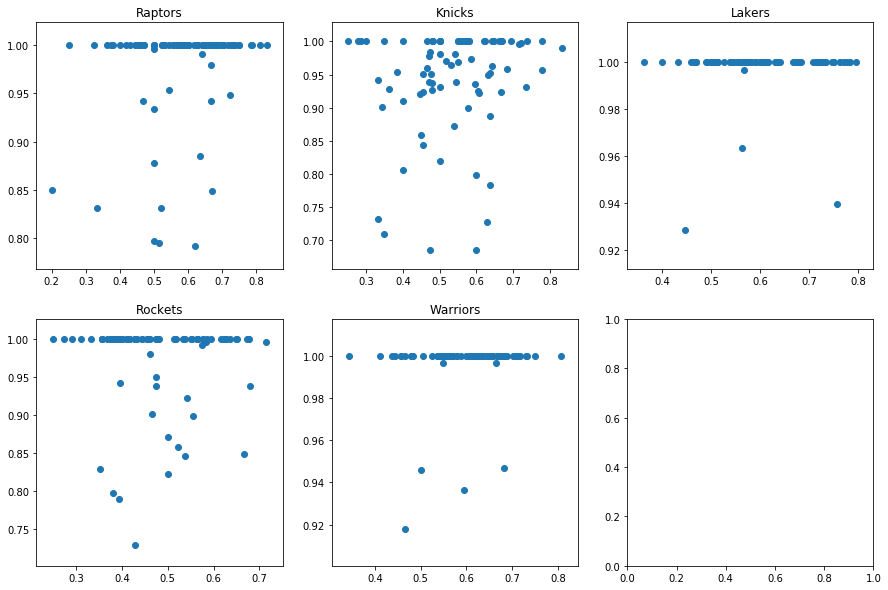

In [117]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(raptors_attendance['Polarized Sentiment Ratio'], raptors_attendance['Attendance Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.scatter(knicks_attendance['Polarized Sentiment Ratio'], knicks_attendance['Attendance Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.scatter(lakers_attendance['Polarized Sentiment Ratio'], lakers_attendance['Attendance Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.scatter(rockets_attendance['Polarized Sentiment Ratio'], rockets_attendance['Attendance Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.scatter(warriors_attendance['Polarized Sentiment Ratio'], warriors_attendance['Attendance Ratio'])
plt.title('Warriors')

plt.show()

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


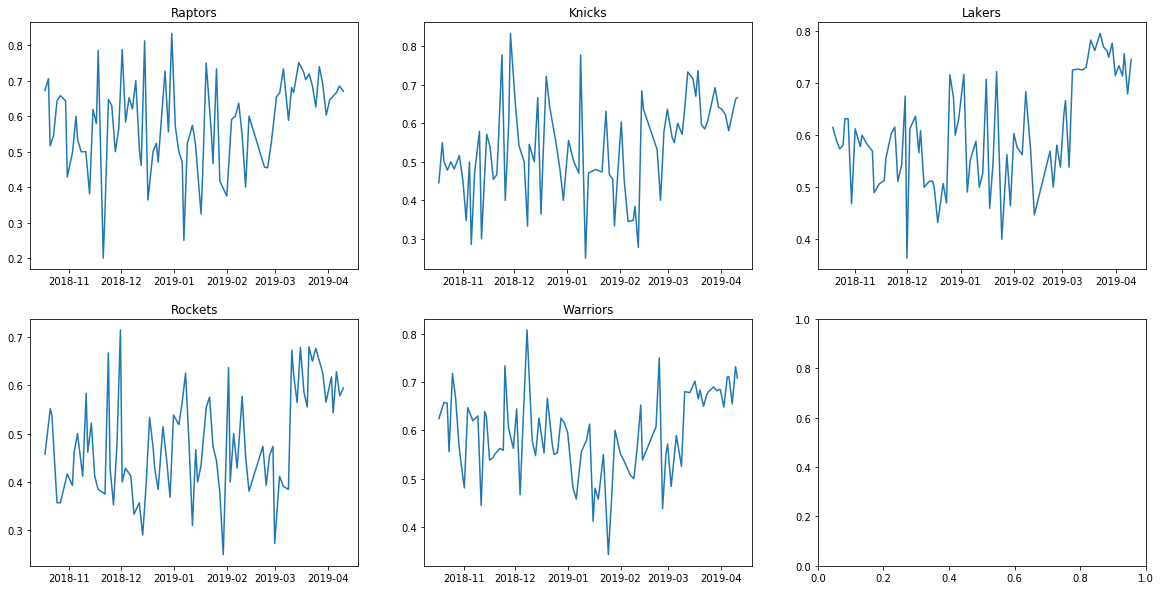

In [118]:
plt.subplots(2,3, figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Polarized Sentiment Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Polarized Sentiment Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Polarized Sentiment Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Polarized Sentiment Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Polarized Sentiment Ratio'])
plt.title('Warriors')

plt.show()

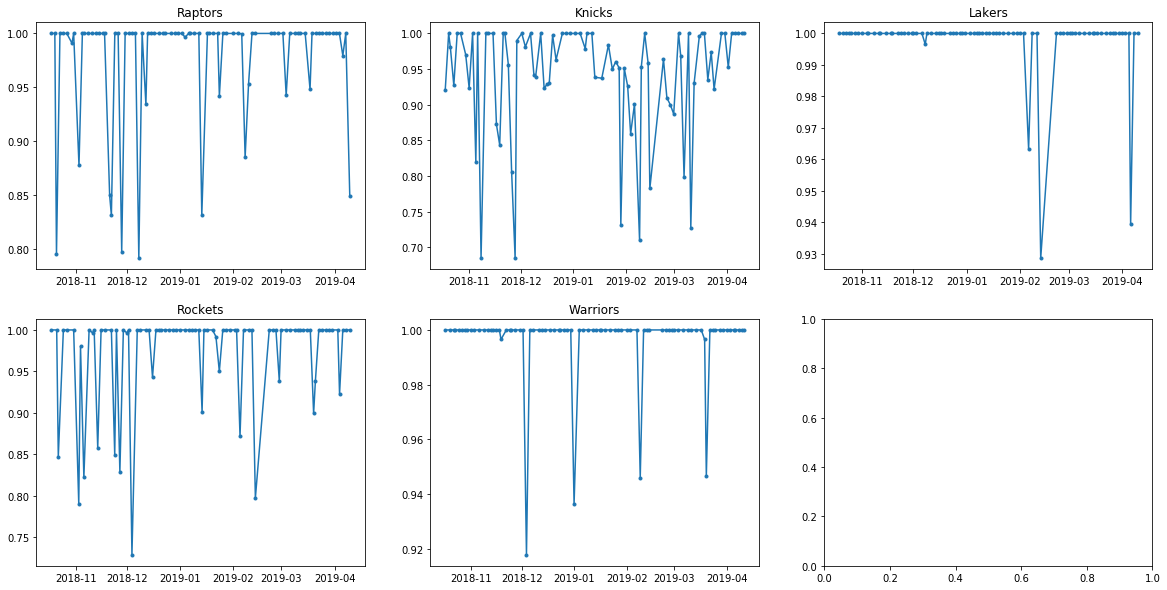

In [119]:
plt.subplots(2,3, figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Attendance Ratio'], marker='.')
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Attendance Ratio'], marker='.')
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Attendance Ratio'], marker='.')
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Attendance Ratio'], marker='.')
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Attendance Ratio'], marker='.')
plt.title('Warriors')

plt.show()

#### Linear Regression Models

In [120]:
#function to run linear regression
def regression_modeler_polar_sent(attendance_df):
    X = attendance_df['Polarized Sentiment Ratio']
    y = attendance_df['Attendance Ratio']
    
    X_withconstant = sm.add_constant(X)
    
    linreg = sm.OLS(y,X_withconstant)
    linreg_results = linreg.fit()
    return linreg_results.summary()

In [121]:
regression_modeler_polar_sent(raptors_attendance)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     3.824
Date:                Sat, 14 Dec 2019   Prob (F-statistic):             0.0540
Time:                        14:28:53   Log-Likelihood:                 125.84
No. Observations:                  82   AIC:                            -247.7
Df Residuals:                      80   BIC:                            -242.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9261      0.027     34.086      0.000       0.872       0.980
Polarized Sentiment Ratio     0.0894      0.046      1.956      0.054      -0.002       0.180
==============================================================================
Omnibus:                       51.475   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.258
Skew:                          -2.287   Prob(JB):                     1.57e-30
Kurtosis:                       7.388   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [122]:
regression_modeler_polar_sent(knicks_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     1.733
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.192
Time:                        14:28:53   Log-Likelihood:                 92.515
No. Observations:                  82   AIC:                            -181.0
Df Residuals:                      80   BIC:                            -176.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.8930      0.039     22.915      0.000       0.815       0.971
Polarized Sentiment Ratio     0.0934      0.071      1.316      0.192      -0.048       0.235
==============================================================================
Omnibus:                       36.187   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               66.131
Skew:                          -1.765   Prob(JB):                     4.36e-15
Kurtosis:                       5.626   Cond. No.                         10.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [123]:
regression_modeler_polar_sent(lakers_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1332
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.716
Time:                        14:28:53   Log-Likelihood:                 254.09
No. Observations:                  82   AIC:                            -504.2
Df Residuals:                      80   BIC:                            -499.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9952      0.007    134.567      0.000       0.981       1.010
Polarized Sentiment Ratio     0.0044      0.012      0.365      0.716      -0.020       0.028
==============================================================================
Omnibus:                      125.484   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3048.293
Skew:                          -5.360   Prob(JB):                         0.00
Kurtosis:                      30.879   Cond. No.                         13.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
regression_modeler_polar_sent(rockets_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.06737
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.796
Time:                        14:28:53   Log-Likelihood:                 115.71
No. Observations:                  82   AIC:                            -227.4
Df Residuals:                      80   BIC:                            -222.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9661      0.030     31.810      0.000       0.906       1.027
Polarized Sentiment Ratio     0.0159      0.061      0.260      0.796      -0.106       0.138
==============================================================================
Omnibus:                       52.328   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              142.427
Skew:                          -2.318   Prob(JB):                     1.18e-31
Kurtosis:                       7.494   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [125]:
regression_modeler_polar_sent(warriors_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9656
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.329
Time:                        14:28:53   Log-Likelihood:                 235.00
No. Observations:                  82   AIC:                            -466.0
Df Residuals:                      80   BIC:                            -461.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9864      0.011     92.190      0.000       0.965       1.008
Polarized Sentiment Ratio     0.0175      0.018      0.983      0.329      -0.018       0.053
==============================================================================
Omnibus:                      104.429   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1317.955
Skew:                          -4.316   Prob(JB):                    6.45e-287
Kurtosis:                      20.642   Cond. No.                         15.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Positive Sentiment Effect

In [126]:
#function to find positive sentiment (positive/total tweets) prior to games
def pos_sentiment_ratio_calc(attendance_df, team_df):
    attendance_df['Positive Sentiment Ratio'] = np.nan
    for index, row in attendance_df.iterrows():
        if index == 0:
            before_game = team_df[team_df['Date'] < attendance_df['Date'][index]]
            attendance_df['Positive Sentiment Ratio'][index] = ((before_game['Sentiment'] == 2).sum()) / before_game['Sentiment'].count()
        else:
            before_game = team_df[(team_df['Date'] < attendance_df['Date'][index]) & (attendance_df['Date'][(index-1)] <= team_df['Date'])]
            attendance_df['Positive Sentiment Ratio'][index] = ((before_game['Sentiment'] == 2).sum()) / before_game['Sentiment'].count()
    return attendance_df

Raptors

In [127]:
pos_sentiment_ratio_calc(raptors_attendance, raptors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio
0,7,2018-10-17 19:30:00+00:00,7:30p,Cleveland Cavaliers,104,Toronto Raptors,116,Box Score,NaN,19915,NaN,19800,1.000000,0.672414,0.413793
1,21,2018-10-19 20:00:00+00:00,8:00p,Boston Celtics,101,Toronto Raptors,113,Box Score,NaN,19800,NaN,19800,1.000000,0.705882,0.323529
2,26,2018-10-20 19:00:00+00:00,7:00p,Toronto Raptors,117,Washington Wizards,113,Box Score,NaN,16185,NaN,20356,0.795097,0.516129,0.322581
3,40,2018-10-22 19:30:00+00:00,7:30p,Charlotte Hornets,106,Toronto Raptors,127,Box Score,NaN,19800,NaN,19800,1.000000,0.545455,0.181818
4,54,2018-10-24 19:30:00+00:00,7:30p,Minnesota Timberwolves,105,Toronto Raptors,112,Box Score,NaN,19800,NaN,19800,1.000000,0.642857,0.392857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1155,2019-04-01 19:30:00+00:00,7:30p,Orlando Magic,109,Toronto Raptors,121,Box Score,NaN,19800,NaN,19800,1.000000,0.645455,0.154545
78,1168,2019-04-03 19:30:00+00:00,7:30p,Toronto Raptors,115,Brooklyn Nets,105,Box Score,NaN,17732,NaN,17732,1.000000,0.656250,0.265625
79,1179,2019-04-05 19:00:00+00:00,7:00p,Toronto Raptors,111,Charlotte Hornets,113,Box Score,NaN,18684,NaN,19077,0.979399,0.666667,0.138211
80,1194,2019-04-07 12:00:00+00:00,12:00p,Miami Heat,109,Toronto Raptors,117,Box Score,OT,19800,NaN,19800,1.000000,0.685039,0.204724


Knicks

In [128]:
pos_sentiment_ratio_calc(knicks_attendance, knicks)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio
0,6,2018-10-17 19:30:00+00:00,7:30p,Atlanta Hawks,107,New York Knicks,126,Box Score,NaN,18249,NaN,19812,0.921108,0.445946,0.162162
1,17,2018-10-19 19:30:00+00:00,7:30p,New York Knicks,105,Brooklyn Nets,107,Box Score,NaN,17732,NaN,17732,1.000000,0.550000,0.300000
2,27,2018-10-20 19:30:00+00:00,7:30p,Boston Celtics,103,New York Knicks,101,Box Score,NaN,19427,NaN,19812,0.980567,0.500000,0.071429
3,41,2018-10-22 20:00:00+00:00,8:00p,New York Knicks,113,Milwaukee Bucks,124,Box Score,NaN,16228,NaN,17500,0.927314,0.478261,0.173913
4,53,2018-10-24 19:30:00+00:00,7:30p,New York Knicks,87,Miami Heat,110,Box Score,NaN,19600,NaN,19600,1.000000,0.500000,0.062500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1165,2019-04-03 19:00:00+00:00,7:00p,New York Knicks,100,Orlando Magic,114,Box Score,NaN,18846,NaN,18846,1.000000,0.623288,0.150685
78,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.580882,0.102941
79,1203,2019-04-07 19:30:00+00:00,7:30p,Washington Wizards,110,New York Knicks,113,Box Score,NaN,19812,NaN,19812,1.000000,0.621429,0.114286
80,1212,2019-04-09 20:00:00+00:00,8:00p,New York Knicks,96,Chicago Bulls,86,Box Score,NaN,21350,NaN,20917,1.000000,0.662500,0.118750


Lakers

In [129]:
pos_sentiment_ratio_calc(lakers_attendance, lakers)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio
0,15,2018-10-18 22:30:00+00:00,10:30p,Los Angeles Lakers,119,Portland Trail Blazers,128,Box Score,NaN,19996,NaN,19441,1.00000,0.614865,0.199324
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.00000,0.591667,0.208333
2,47,2018-10-22 22:30:00+00:00,10:30p,San Antonio Spurs,143,Los Angeles Lakers,142,Box Score,OT,18997,NaN,18997,1.00000,0.573529,0.213235
3,59,2018-10-24 22:00:00+00:00,10:00p,Los Angeles Lakers,131,Phoenix Suns,113,Box Score,NaN,18055,NaN,18055,1.00000,0.580645,0.209677
4,65,2018-10-25 22:30:00+00:00,10:30p,Denver Nuggets,114,Los Angeles Lakers,121,Box Score,NaN,18997,NaN,18997,1.00000,0.631579,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1160,2019-04-02 20:00:00+00:00,8:00p,Los Angeles Lakers,103,Oklahoma City Thunder,119,Box Score,NaN,18203,NaN,18203,1.00000,0.733681,0.185379
78,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.00000,0.713821,0.126829
79,1191,2019-04-05 22:30:00+00:00,10:30p,Los Angeles Lakers,122,Los Angeles Clippers,117,Box Score,NaN,17910,NaN,19068,0.93927,0.756410,0.179487
80,1207,2019-04-07 21:30:00+00:00,9:30p,Utah Jazz,109,Los Angeles Lakers,113,Box Score,NaN,18997,NaN,18997,1.00000,0.679121,0.178022


Rockets

In [130]:
pos_sentiment_ratio_calc(rockets_attendance, rockets)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio
0,8,2018-10-17 20:00:00+00:00,8:00p,New Orleans Pelicans,131,Houston Rockets,112,Box Score,NaN,18055,NaN,18055,1.000000,0.457627,0.169492
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.000000,0.551724,0.103448
2,38,2018-10-21 21:00:00+00:00,9:00p,Houston Rockets,112,Los Angeles Clippers,115,Box Score,NaN,16149,NaN,19068,0.846916,0.537037,0.055556
3,56,2018-10-24 20:00:00+00:00,8:00p,Utah Jazz,100,Houston Rockets,89,Box Score,NaN,18055,NaN,18055,1.000000,0.357143,0.095238
4,69,2018-10-26 20:00:00+00:00,8:00p,Los Angeles Clippers,133,Houston Rockets,113,Box Score,NaN,18055,NaN,18055,1.000000,0.357143,0.214286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1162,2019-04-02 22:00:00+00:00,10:00p,Houston Rockets,130,Sacramento Kings,105,Box Score,NaN,17583,NaN,17583,1.000000,0.617424,0.159091
78,1175,2019-04-03 22:30:00+00:00,10:30p,Houston Rockets,135,Los Angeles Clippers,103,Box Score,NaN,17593,NaN,19068,0.922645,0.542857,0.120000
79,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.627737,0.171533
80,1200,2019-04-07 19:00:00+00:00,7:00p,Phoenix Suns,113,Houston Rockets,149,Box Score,NaN,18055,NaN,18055,1.000000,0.577982,0.197248


Warriors

In [131]:
pos_sentiment_ratio_calc(warriors_attendance, warriors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio
0,1,2018-10-16 22:30:00+00:00,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,NaN,18064,1.0,0.624365,0.274112
1,24,2018-10-19 22:30:00+00:00,10:30p,Golden State Warriors,124,Utah Jazz,123,Box Score,NaN,18306,NaN,18306,1.0,0.657534,0.232877
2,37,2018-10-21 20:00:00+00:00,8:00p,Golden State Warriors,98,Denver Nuggets,100,Box Score,NaN,19520,NaN,19520,1.0,0.656250,0.187500
3,46,2018-10-22 22:30:00+00:00,10:30p,Phoenix Suns,103,Golden State Warriors,123,Box Score,NaN,19596,NaN,18064,1.0,0.555556,0.166667
4,61,2018-10-24 22:30:00+00:00,10:30p,Washington Wizards,122,Golden State Warriors,144,Box Score,NaN,19596,NaN,18064,1.0,0.717949,0.307692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.0,0.710280,0.179907
78,1190,2019-04-05 22:30:00+00:00,10:30p,Cleveland Cavaliers,114,Golden State Warriors,120,Box Score,NaN,19596,NaN,18064,1.0,0.710900,0.199052
79,1204,2019-04-07 20:30:00+00:00,8:30p,Los Angeles Clippers,104,Golden State Warriors,131,Box Score,NaN,19596,NaN,18064,1.0,0.654628,0.248307
80,1214,2019-04-09 20:00:00+00:00,8:00p,Golden State Warriors,112,New Orleans Pelicans,103,Box Score,NaN,17090,NaN,16867,1.0,0.731638,0.225989


#### Plots

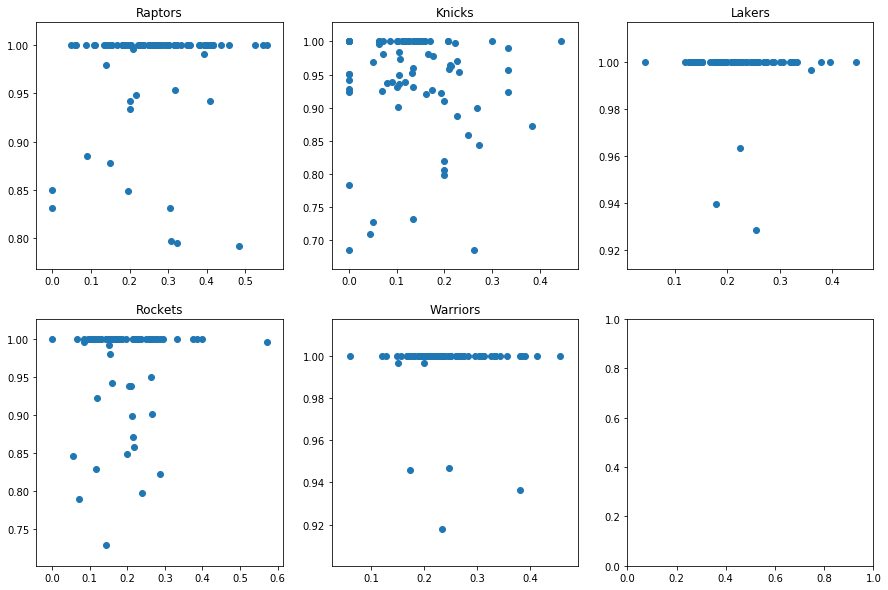

In [132]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(raptors_attendance['Positive Sentiment Ratio'], raptors_attendance['Attendance Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.scatter(knicks_attendance['Positive Sentiment Ratio'], knicks_attendance['Attendance Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.scatter(lakers_attendance['Positive Sentiment Ratio'], lakers_attendance['Attendance Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.scatter(rockets_attendance['Positive Sentiment Ratio'], rockets_attendance['Attendance Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.scatter(warriors_attendance['Positive Sentiment Ratio'], warriors_attendance['Attendance Ratio'])
plt.title('Warriors')

plt.show()

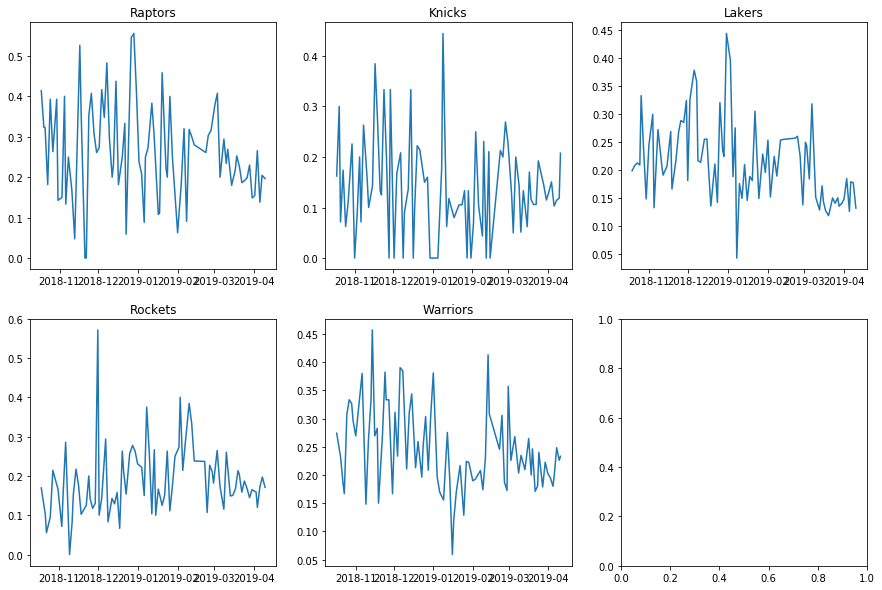

In [133]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Positive Sentiment Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Positive Sentiment Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Positive Sentiment Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Positive Sentiment Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Positive Sentiment Ratio'])
plt.title('Warriors')

plt.show()

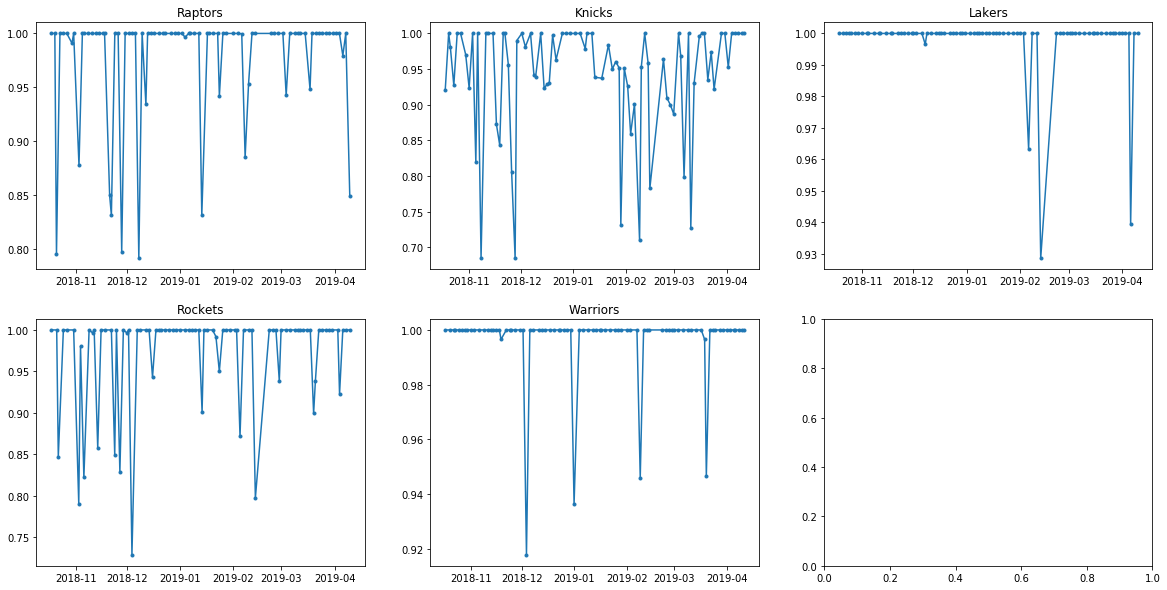

In [134]:
plt.subplots(2,3, figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Attendance Ratio'], marker='.')
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Attendance Ratio'], marker='.')
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Attendance Ratio'], marker='.')
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Attendance Ratio'], marker='.')
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Attendance Ratio'], marker='.')
plt.title('Warriors')

plt.show()

#### Linear Regression Models

In [135]:
#function to run linear regression
def regression_modeler_pos_sent(attendance_df):
    X = attendance_df['Positive Sentiment Ratio']
    y = attendance_df['Attendance Ratio']
    
    X_withconstant = sm.add_constant(X)
    
    linreg = sm.OLS(y,X_withconstant)
    linreg_results = linreg.fit()
    return linreg_results.summary()

In [136]:
regression_modeler_pos_sent(raptors_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9134
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.342
Time:                        14:28:59   Log-Likelihood:                 124.39
No. Observations:                  82   AIC:                            -244.8
Df Residuals:                      80   BIC:                            -240.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9654      0.014     66.895      0.000       0.937       0.994
Positive Sentiment Ratio     0.0477      0.050      0.956      0.342      -0.052       0.147
==============================================================================
Omnibus:                       56.381   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              168.808
Skew:                          -2.468   Prob(JB):                     2.21e-37
Kurtosis:                       8.003   Cond. No.                         9.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [137]:
regression_modeler_pos_sent(knicks_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                   0.09620
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.757
Time:                        14:28:59   Log-Likelihood:                 91.685
No. Observations:                  82   AIC:                            -179.4
Df Residuals:                      80   BIC:                            -174.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9470      0.016     60.560      0.000       0.916       0.978
Positive Sentiment Ratio    -0.0288      0.093     -0.310      0.757      -0.213       0.156
==============================================================================
Omnibus:                       37.897   Durbin-Watson:                   1.914
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.683
Skew:                          -1.832   Prob(JB):                     2.72e-16
Kurtosis:                       5.748   Cond. No.                         10.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [138]:
regression_modeler_pos_sent(lakers_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.05106
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.822
Time:                        14:28:59   Log-Likelihood:                 254.04
No. Observations:                  82   AIC:                            -504.1
Df Residuals:                      80   BIC:                            -499.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9987      0.004    257.425      0.000       0.991       1.006
Positive Sentiment Ratio    -0.0039      0.017     -0.226      0.822      -0.038       0.030
==============================================================================
Omnibus:                      125.795   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3085.880
Skew:                          -5.377   Prob(JB):                         0.00
Kurtosis:                      31.063   Cond. No.                         14.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [139]:
regression_modeler_pos_sent(rockets_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.2752
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.601
Time:                        14:28:59   Log-Likelihood:                 115.82
No. Observations:                  82   AIC:                            -227.6
Df Residuals:                      80   BIC:                            -222.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9662      0.016     60.903      0.000       0.935       0.998
Positive Sentiment Ratio     0.0401      0.076      0.525      0.601      -0.112       0.192
==============================================================================
Omnibus:                       52.092   Durbin-Watson:                   2.316
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.071
Skew:                          -2.309   Prob(JB):                     2.33e-31
Kurtosis:                       7.469   Cond. No.                         12.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [140]:
regression_modeler_pos_sent(warriors_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1033
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.749
Time:                        14:28:59   Log-Likelihood:                 234.56
No. Observations:                  82   AIC:                            -465.1
Df Residuals:                      80   BIC:                            -460.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9985      0.005    186.123      0.000       0.988       1.009
Positive Sentiment Ratio    -0.0067      0.021     -0.321      0.749      -0.048       0.035
==============================================================================
Omnibus:                      106.640   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1434.049
Skew:                          -4.421   Prob(JB):                         0.00
Kurtosis:                      21.480   Cond. No.                         14.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Negative Sentiment Effect

In [141]:
#function to find negative sentiment (positive/total tweets) prior to games
def neg_sentiment_ratio_calc(attendance_df, team_df):
    attendance_df['Negative Sentiment Ratio'] = np.nan
    for index, row in attendance_df.iterrows():
        if index == 0:
            before_game = team_df[team_df['Date'] < attendance_df['Date'][index]]
            attendance_df['Negative Sentiment Ratio'][index] = ((before_game['Sentiment'] == 0).sum()) / before_game['Sentiment'].count()
        else:
            before_game = team_df[(team_df['Date'] < attendance_df['Date'][index]) & (attendance_df['Date'][(index-1)] <= team_df['Date'])]
            attendance_df['Negative Sentiment Ratio'][index] = ((before_game['Sentiment'] == 0).sum()) / before_game['Sentiment'].count()
    return attendance_df

Raptors

In [142]:
neg_sentiment_ratio_calc(raptors_attendance, raptors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio,Negative Sentiment Ratio
0,7,2018-10-17 19:30:00+00:00,7:30p,Cleveland Cavaliers,104,Toronto Raptors,116,Box Score,NaN,19915,NaN,19800,1.000000,0.672414,0.413793,0.258621
1,21,2018-10-19 20:00:00+00:00,8:00p,Boston Celtics,101,Toronto Raptors,113,Box Score,NaN,19800,NaN,19800,1.000000,0.705882,0.323529,0.382353
2,26,2018-10-20 19:00:00+00:00,7:00p,Toronto Raptors,117,Washington Wizards,113,Box Score,NaN,16185,NaN,20356,0.795097,0.516129,0.322581,0.193548
3,40,2018-10-22 19:30:00+00:00,7:30p,Charlotte Hornets,106,Toronto Raptors,127,Box Score,NaN,19800,NaN,19800,1.000000,0.545455,0.181818,0.363636
4,54,2018-10-24 19:30:00+00:00,7:30p,Minnesota Timberwolves,105,Toronto Raptors,112,Box Score,NaN,19800,NaN,19800,1.000000,0.642857,0.392857,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1155,2019-04-01 19:30:00+00:00,7:30p,Orlando Magic,109,Toronto Raptors,121,Box Score,NaN,19800,NaN,19800,1.000000,0.645455,0.154545,0.490909
78,1168,2019-04-03 19:30:00+00:00,7:30p,Toronto Raptors,115,Brooklyn Nets,105,Box Score,NaN,17732,NaN,17732,1.000000,0.656250,0.265625,0.390625
79,1179,2019-04-05 19:00:00+00:00,7:00p,Toronto Raptors,111,Charlotte Hornets,113,Box Score,NaN,18684,NaN,19077,0.979399,0.666667,0.138211,0.528455
80,1194,2019-04-07 12:00:00+00:00,12:00p,Miami Heat,109,Toronto Raptors,117,Box Score,OT,19800,NaN,19800,1.000000,0.685039,0.204724,0.480315


Knicks

In [143]:
neg_sentiment_ratio_calc(knicks_attendance, knicks)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio,Negative Sentiment Ratio
0,6,2018-10-17 19:30:00+00:00,7:30p,Atlanta Hawks,107,New York Knicks,126,Box Score,NaN,18249,NaN,19812,0.921108,0.445946,0.162162,0.283784
1,17,2018-10-19 19:30:00+00:00,7:30p,New York Knicks,105,Brooklyn Nets,107,Box Score,NaN,17732,NaN,17732,1.000000,0.550000,0.300000,0.250000
2,27,2018-10-20 19:30:00+00:00,7:30p,Boston Celtics,103,New York Knicks,101,Box Score,NaN,19427,NaN,19812,0.980567,0.500000,0.071429,0.428571
3,41,2018-10-22 20:00:00+00:00,8:00p,New York Knicks,113,Milwaukee Bucks,124,Box Score,NaN,16228,NaN,17500,0.927314,0.478261,0.173913,0.304348
4,53,2018-10-24 19:30:00+00:00,7:30p,New York Knicks,87,Miami Heat,110,Box Score,NaN,19600,NaN,19600,1.000000,0.500000,0.062500,0.437500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1165,2019-04-03 19:00:00+00:00,7:00p,New York Knicks,100,Orlando Magic,114,Box Score,NaN,18846,NaN,18846,1.000000,0.623288,0.150685,0.472603
78,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.580882,0.102941,0.477941
79,1203,2019-04-07 19:30:00+00:00,7:30p,Washington Wizards,110,New York Knicks,113,Box Score,NaN,19812,NaN,19812,1.000000,0.621429,0.114286,0.507143
80,1212,2019-04-09 20:00:00+00:00,8:00p,New York Knicks,96,Chicago Bulls,86,Box Score,NaN,21350,NaN,20917,1.000000,0.662500,0.118750,0.543750


Lakers

In [144]:
neg_sentiment_ratio_calc(lakers_attendance, lakers)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio,Negative Sentiment Ratio
0,15,2018-10-18 22:30:00+00:00,10:30p,Los Angeles Lakers,119,Portland Trail Blazers,128,Box Score,NaN,19996,NaN,19441,1.00000,0.614865,0.199324,0.415541
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.00000,0.591667,0.208333,0.383333
2,47,2018-10-22 22:30:00+00:00,10:30p,San Antonio Spurs,143,Los Angeles Lakers,142,Box Score,OT,18997,NaN,18997,1.00000,0.573529,0.213235,0.360294
3,59,2018-10-24 22:00:00+00:00,10:00p,Los Angeles Lakers,131,Phoenix Suns,113,Box Score,NaN,18055,NaN,18055,1.00000,0.580645,0.209677,0.370968
4,65,2018-10-25 22:30:00+00:00,10:30p,Denver Nuggets,114,Los Angeles Lakers,121,Box Score,NaN,18997,NaN,18997,1.00000,0.631579,0.333333,0.298246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1160,2019-04-02 20:00:00+00:00,8:00p,Los Angeles Lakers,103,Oklahoma City Thunder,119,Box Score,NaN,18203,NaN,18203,1.00000,0.733681,0.185379,0.548303
78,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.00000,0.713821,0.126829,0.586992
79,1191,2019-04-05 22:30:00+00:00,10:30p,Los Angeles Lakers,122,Los Angeles Clippers,117,Box Score,NaN,17910,NaN,19068,0.93927,0.756410,0.179487,0.576923
80,1207,2019-04-07 21:30:00+00:00,9:30p,Utah Jazz,109,Los Angeles Lakers,113,Box Score,NaN,18997,NaN,18997,1.00000,0.679121,0.178022,0.501099


Rockets

In [145]:
neg_sentiment_ratio_calc(rockets_attendance, rockets)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio,Negative Sentiment Ratio
0,8,2018-10-17 20:00:00+00:00,8:00p,New Orleans Pelicans,131,Houston Rockets,112,Box Score,NaN,18055,NaN,18055,1.000000,0.457627,0.169492,0.288136
1,34,2018-10-20 22:30:00+00:00,10:30p,Houston Rockets,124,Los Angeles Lakers,115,Box Score,NaN,18997,NaN,18997,1.000000,0.551724,0.103448,0.448276
2,38,2018-10-21 21:00:00+00:00,9:00p,Houston Rockets,112,Los Angeles Clippers,115,Box Score,NaN,16149,NaN,19068,0.846916,0.537037,0.055556,0.481481
3,56,2018-10-24 20:00:00+00:00,8:00p,Utah Jazz,100,Houston Rockets,89,Box Score,NaN,18055,NaN,18055,1.000000,0.357143,0.095238,0.261905
4,69,2018-10-26 20:00:00+00:00,8:00p,Los Angeles Clippers,133,Houston Rockets,113,Box Score,NaN,18055,NaN,18055,1.000000,0.357143,0.214286,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1162,2019-04-02 22:00:00+00:00,10:00p,Houston Rockets,130,Sacramento Kings,105,Box Score,NaN,17583,NaN,17583,1.000000,0.617424,0.159091,0.458333
78,1175,2019-04-03 22:30:00+00:00,10:30p,Houston Rockets,135,Los Angeles Clippers,103,Box Score,NaN,17593,NaN,19068,0.922645,0.542857,0.120000,0.422857
79,1182,2019-04-05 20:00:00+00:00,8:00p,New York Knicks,96,Houston Rockets,120,Box Score,NaN,18055,NaN,18055,1.000000,0.627737,0.171533,0.456204
80,1200,2019-04-07 19:00:00+00:00,7:00p,Phoenix Suns,113,Houston Rockets,149,Box Score,NaN,18055,NaN,18055,1.000000,0.577982,0.197248,0.380734


Warriors

In [146]:
neg_sentiment_ratio_calc(warriors_attendance, warriors)

C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\mitch\Anaconda3\envs\neuralnetworks\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,index,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes,Capacity,Attendance Ratio,Polarized Sentiment Ratio,Positive Sentiment Ratio,Negative Sentiment Ratio
0,1,2018-10-16 22:30:00+00:00,10:30p,Oklahoma City Thunder,100,Golden State Warriors,108,Box Score,NaN,19596,NaN,18064,1.0,0.624365,0.274112,0.350254
1,24,2018-10-19 22:30:00+00:00,10:30p,Golden State Warriors,124,Utah Jazz,123,Box Score,NaN,18306,NaN,18306,1.0,0.657534,0.232877,0.424658
2,37,2018-10-21 20:00:00+00:00,8:00p,Golden State Warriors,98,Denver Nuggets,100,Box Score,NaN,19520,NaN,19520,1.0,0.656250,0.187500,0.468750
3,46,2018-10-22 22:30:00+00:00,10:30p,Phoenix Suns,103,Golden State Warriors,123,Box Score,NaN,19596,NaN,18064,1.0,0.555556,0.166667,0.388889
4,61,2018-10-24 22:30:00+00:00,10:30p,Washington Wizards,122,Golden State Warriors,144,Box Score,NaN,19596,NaN,18064,1.0,0.717949,0.307692,0.410256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1178,2019-04-04 22:30:00+00:00,10:30p,Golden State Warriors,108,Los Angeles Lakers,90,Box Score,NaN,18997,NaN,18997,1.0,0.710280,0.179907,0.530374
78,1190,2019-04-05 22:30:00+00:00,10:30p,Cleveland Cavaliers,114,Golden State Warriors,120,Box Score,NaN,19596,NaN,18064,1.0,0.710900,0.199052,0.511848
79,1204,2019-04-07 20:30:00+00:00,8:30p,Los Angeles Clippers,104,Golden State Warriors,131,Box Score,NaN,19596,NaN,18064,1.0,0.654628,0.248307,0.406321
80,1214,2019-04-09 20:00:00+00:00,8:00p,Golden State Warriors,112,New Orleans Pelicans,103,Box Score,NaN,17090,NaN,16867,1.0,0.731638,0.225989,0.505650


#### Plots

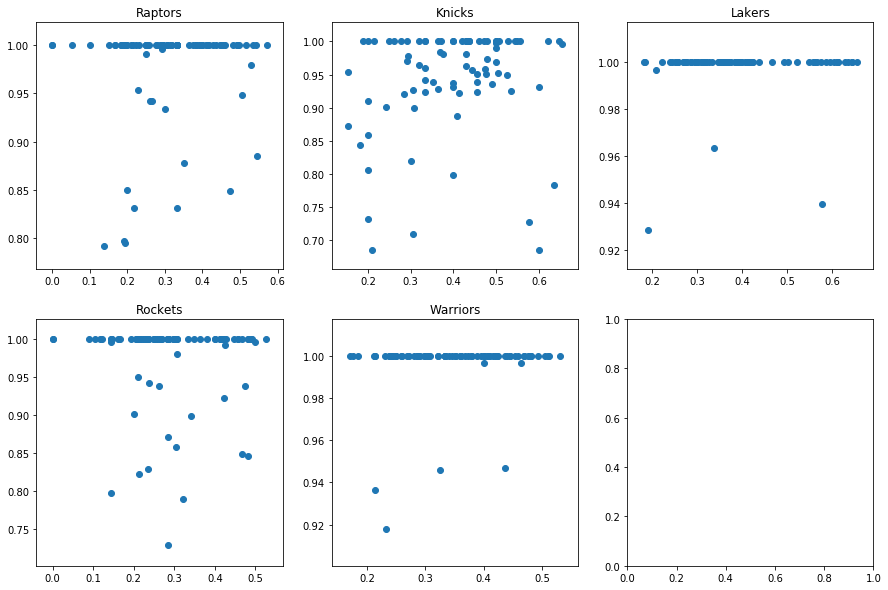

In [147]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
plt.scatter(raptors_attendance['Negative Sentiment Ratio'], raptors_attendance['Attendance Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.scatter(knicks_attendance['Negative Sentiment Ratio'], knicks_attendance['Attendance Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.scatter(lakers_attendance['Negative Sentiment Ratio'], lakers_attendance['Attendance Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.scatter(rockets_attendance['Negative Sentiment Ratio'], rockets_attendance['Attendance Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.scatter(warriors_attendance['Negative Sentiment Ratio'], warriors_attendance['Attendance Ratio'])
plt.title('Warriors')

plt.show()

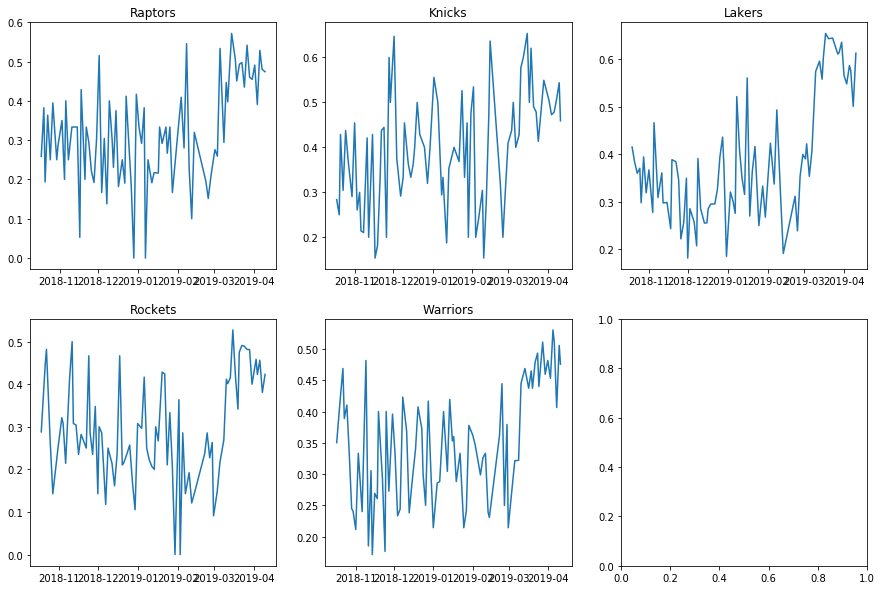

In [148]:
plt.subplots(2,3, figsize=(15,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Negative Sentiment Ratio'])
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Negative Sentiment Ratio'])
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Negative Sentiment Ratio'])
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Negative Sentiment Ratio'])
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Negative Sentiment Ratio'])
plt.title('Warriors')

plt.show()

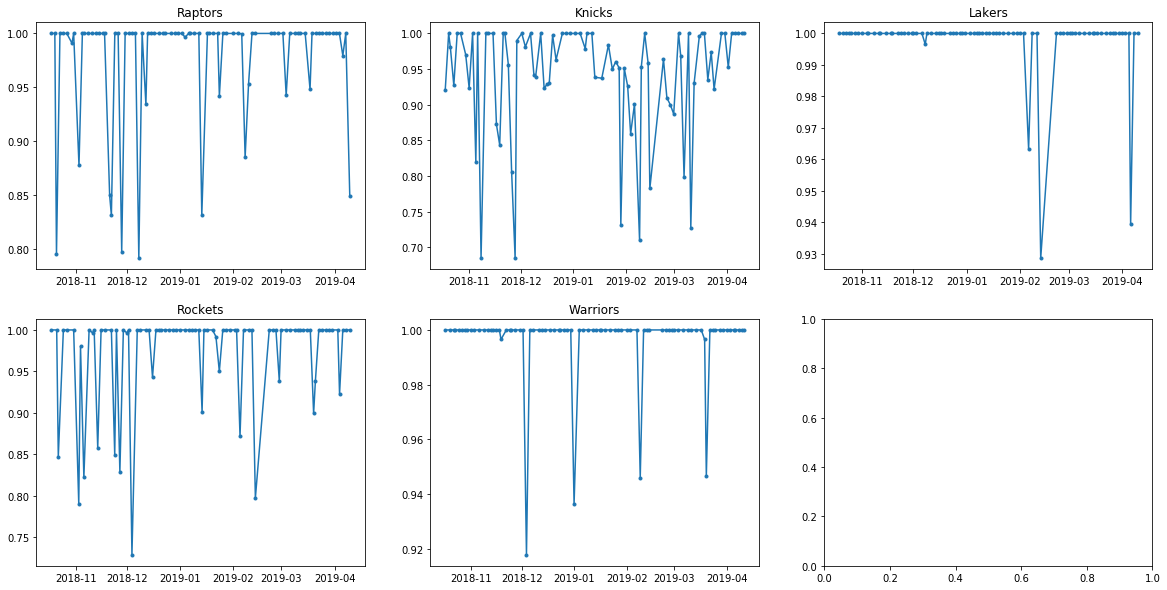

In [149]:
plt.subplots(2,3, figsize=(20,10))

plt.subplot(2,3,1)
plt.plot(raptors_attendance['Date'], raptors_attendance['Attendance Ratio'], marker='.')
plt.title('Raptors')

plt.subplot(2,3,2)
plt.plot(knicks_attendance['Date'], knicks_attendance['Attendance Ratio'], marker='.')
plt.title('Knicks')

plt.subplot(2,3,3)
plt.plot(lakers_attendance['Date'], lakers_attendance['Attendance Ratio'], marker='.')
plt.title('Lakers')

plt.subplot(2,3,4)
plt.plot(rockets_attendance['Date'], rockets_attendance['Attendance Ratio'], marker='.')
plt.title('Rockets')

plt.subplot(2,3,5)
plt.plot(warriors_attendance['Date'], warriors_attendance['Attendance Ratio'], marker='.')
plt.title('Warriors')

plt.show()

#### Linear Regression Models

In [150]:
#function to run linear regression
def regression_modeler_neg_sent(attendance_df):
    X = attendance_df['Negative Sentiment Ratio']
    y = attendance_df['Attendance Ratio']
    
    X_withconstant = sm.add_constant(X)
    
    linreg = sm.OLS(y,X_withconstant)
    linreg_results = linreg.fit()
    return linreg_results.summary()

In [151]:
regression_modeler_neg_sent(raptors_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.082
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.301
Time:                        14:29:02   Log-Likelihood:                 124.47
No. Observations:                  82   AIC:                            -244.9
Df Residuals:                      80   BIC:                            -240.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9625      0.016     60.185      0.000       0.931       0.994
Negative Sentiment Ratio     0.0487      0.047      1.040      0.301      -0.044       0.142
==============================================================================
Omnibus:                       51.420   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              131.893
Skew:                          -2.327   Prob(JB):                     2.29e-29
Kurtosis:                       7.115   Cond. No.                         8.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [152]:
regression_modeler_neg_sent(knicks_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     2.384
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.127
Time:                        14:29:02   Log-Likelihood:                 92.840
No. Observations:                  82   AIC:                            -181.7
Df Residuals:                      80   BIC:                            -176.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9003      0.029     31.081      0.000       0.843       0.958
Negative Sentiment Ratio     0.1076      0.070      1.544      0.127      -0.031       0.246
==============================================================================
Omnibus:                       40.072   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.814
Skew:                          -1.877   Prob(JB):                     1.72e-18
Kurtosis:                       6.140   Cond. No.                         9.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [153]:
regression_modeler_neg_sent(lakers_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                    0.1715
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.680
Time:                        14:29:02   Log-Likelihood:                 254.11
No. Observations:                  82   AIC:                            -504.2
Df Residuals:                      80   BIC:                            -499.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9964      0.004    254.967      0.000       0.989       1.004
Negative Sentiment Ratio     0.0039      0.010      0.414      0.680      -0.015       0.023
==============================================================================
Omnibus:                      125.453   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3044.215
Skew:                          -5.359   Prob(JB):                         0.00
Kurtosis:                      30.859   Cond. No.                         9.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [154]:
regression_modeler_neg_sent(rockets_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                   0.02012
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.888
Time:                        14:29:02   Log-Likelihood:                 115.69
No. Observations:                  82   AIC:                            -227.4
Df Residuals:                      80   BIC:                            -222.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9761      0.017     56.107      0.000       0.941       1.011
Negative Sentiment Ratio    -0.0077      0.054     -0.142      0.888      -0.116       0.101
==============================================================================
Omnibus:                       53.033   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              147.410
Skew:                          -2.339   Prob(JB):                     9.78e-33
Kurtosis:                       7.611   Cond. No.                         8.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [155]:
regression_modeler_neg_sent(warriors_attendance)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Attendance Ratio   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.392
Date:                Sat, 14 Dec 2019   Prob (F-statistic):              0.242
Time:                        14:29:02   Log-Likelihood:                 235.22
No. Observations:                  82   AIC:                            -466.4
Df Residuals:                      80   BIC:                            -461.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9900      0.006    165.740      0.000       0.978       1.002
Negative Sentiment Ratio     0.0196      0.017      1.180      0.242      -0.013       0.053
==============================================================================
Omnibus:                      103.480   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1277.881
Skew:                          -4.267   Prob(JB):                    3.25e-278
Kurtosis:                      20.355   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Export Final CSVs for high quality visualization

In [156]:
raptors_attendance['At Home'] = raptors_attendance['Home/Neutral']
away = raptors_attendance['At Home'] != 'Toronto Raptors'
home = raptors_attendance['At Home'] == 'Toronto Raptors'
raptors_attendance['At Home'].where(away, 'Home', inplace = True)
raptors_attendance['At Home'].where(home, 'Away', inplace = True)

In [157]:
knicks_attendance['At Home'] = knicks_attendance['Home/Neutral']
away = knicks_attendance['At Home'] != 'New York Knicks'
home = knicks_attendance['At Home'] == 'New York Knicks'
knicks_attendance['At Home'].where(away, 'Home', inplace = True)
knicks_attendance['At Home'].where(home, 'Away', inplace = True)

In [158]:
lakers_attendance['At Home'] = lakers_attendance['Home/Neutral']
away = lakers_attendance['At Home'] != 'Los Angeles Lakers'
home = lakers_attendance['At Home'] == 'Los Angeles Lakers'
lakers_attendance['At Home'].where(away, 'Home', inplace = True)
lakers_attendance['At Home'].where(home, 'Away', inplace = True)

In [159]:
rockets_attendance['At Home'] = rockets_attendance['Home/Neutral']
away = rockets_attendance['At Home'] != 'Houston Rockets'
home = rockets_attendance['At Home'] == 'Houston Rockets'
rockets_attendance['At Home'].where(away, 'Home', inplace = True)
rockets_attendance['At Home'].where(home, 'Away', inplace = True)

In [160]:
warriors_attendance['At Home'] = warriors_attendance['Home/Neutral']
away = warriors_attendance['At Home'] != 'Golden State Warriors'
home = warriors_attendance['At Home'] == 'Golden State Warriors'
warriors_attendance['At Home'].where(away, 'Home', inplace = True)
warriors_attendance['At Home'].where(home, 'Away', inplace = True)

In [161]:
raptors_attendance.to_csv('../data/raptors_results.csv')
knicks_attendance.to_csv('../data/knicks_results.csv')
lakers_attendance.to_csv('../data/lakers_results.csv')
rockets_attendance.to_csv('../data/rockets_results.csv')
warriors_attendance.to_csv('../data/warriors_results.csv')